In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import xarray as xr
import pandas as pd
import os, sys
from scipy import interpolate
import cartopy.crs as ccrs
import matplotlib.colors as colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from matplotlib.collections import LineCollection
from matplotlib import cm
from datetime import datetime
import pickle, warnings
from matplotlib.colors import LinearSegmentedColormap
#from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LogLocator, ScalarFormatter
import h5py
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

In [2]:
sys.path.append(os.path.abspath("/groups/sylvia/UTLS-profiles/traj/"))
sys.path.append(os.path.abspath("/groups/sylvia/UTLS-profiles/utilities/"))
sys.path.append(os.path.abspath("/groups/sylvia/UTLS-profiles/syntraj/"))
from traj_psd_obs import traj_psd
from plotting_utilities import *
from mls_regrid_kernel import mls_regrid_kernel
from statisticsFunc import statisticsFunc
#from densityPlot import *
from flighttrack import *
from thermodynamic_functions import print_stats

farbe = sim_colors()

In [3]:
# Constants needed for mixing ratio conversion
mw_dryair = 28.97*1000    # kg air (mol air)-1
mw_watvap = 18.02*1000    # kg wv (mol wv)-1
conv = mw_dryair / mw_watvap
sim_list = ['1M0O','1M1O','1M3O','2M0O','2M1O','2M3O']

# Figure 1: Small subdomain and measurements over domain + synthetic flight track idea

In [4]:
# Flight 7 track
basedir = '/groups/sylvia/UTLS-profiles/'
scfi = basedir + 'obs/stratoclim2017.geophysika.0808_1.master.ci_eval.nc'
sc_data = xr.open_dataset(scfi)
lat_sc = sc_data['BEST:LAT'].values
lon_sc = sc_data['BEST:LON'].values
t_sc = sc_data['time'].values
i_sc = np.argwhere((~np.isnan(lat_sc)) & (~np.isnan(lon_sc)) & (lat_sc > 0) & (lon_sc > 0))

# External parameter file with topography
dset = xr.open_dataset( '/xdisk/sylvia/extpar_icon-grid_tropic_55e115e5s40n_R2500m_bitmap.nc' )

In [5]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=128): #256
    """Truncate a coloramp by specifying the start and endpoint."""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n}.{a:.2f},{b:.2f})'.format(n=cmap.name,a=minval,b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return(new_cmap)

In [6]:
# MLS data
bd = '/groups/sylvia/UTLS-profiles/obs/MLS/'
filename = 'MLS-Aura_L2GP-Temperature_v05-01-c01_2017d220.he5'
with h5py.File( bd + filename, 'r' ) as f:
    mls_temperature = f['HDFEOS/SWATHS/Temperature/Data Fields/Temperature'][:]  # (3495, 55)
    mls_lat = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Latitude'][:] # (3495, )
    mls_lon = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Longitude'][:] # (3495, )
    mls_pressure1 = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Pressure'][:] # (55, )

# Filter for temperature and qv data where lat and lon fall within the box
mask = ( (mls_lon >= 80) & (mls_lon <= 90) & (mls_lat >= 19) & (mls_lat <=30) )
mls_lon_filtered = mls_lon[mask]
mls_lat_filtered = mls_lat[mask]

In [7]:
# Read in a sample 51-hour long trajectory file. Initialize empty arrays for altitude, latitude, longitude.
fi_name = '/groups/sylvia/UTLS-profiles/output/traj_tst00000450_p011.nc'
timesteps = 7651
numtraj = xr.open_dataset(fi_name).dims['id']

traj_alt = np.zeros((timesteps,numtraj))
traj_lat = np.zeros((timesteps,numtraj))
traj_lon = np.zeros((timesteps,numtraj))

In [8]:
# Read in the altitude, longitude, latitude values
n = 150 # How many trajectories to extract?
fi = xr.open_dataset(fi_name)
ids_to_keep = np.random.choice(fi.alt.id.values, size=n, replace=False)
sub = fi.sel(id=ids_to_keep)

# Mask out values where the altitude is 0
mask = sub.alt != 0
alt_sel = sub.alt.where(mask, drop=True)/1000.
lon_sel = rad2deg( sub.lon.where(mask, drop=True) )
lat_sel = rad2deg( sub.lat.where(mask, drop=True) )

# Mask the negative altitudes and fill values (-999.) for latitudes and longitudes.
traj_alt = xr.where( (alt_sel > 0), alt_sel, np.nan )
traj_lat = xr.where( (lat_sel >= -90.), lat_sel, np.nan )
traj_lon = xr.where( (lon_sel >= -180.), lon_sel, np.nan )

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.


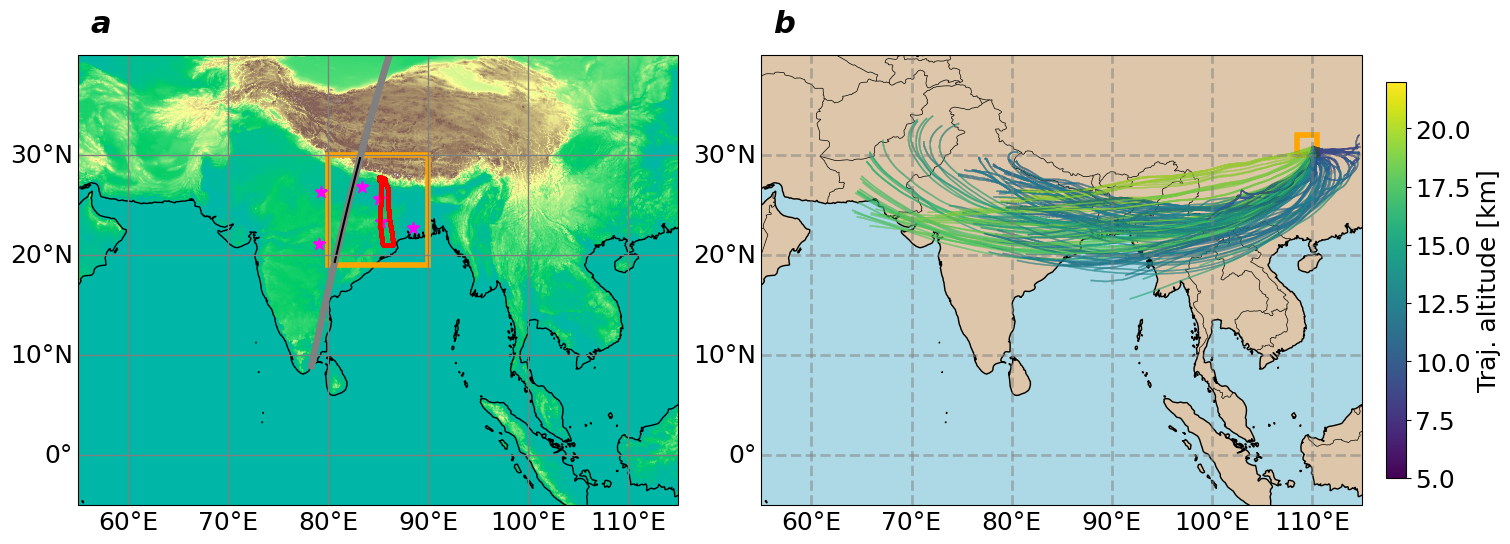

In [9]:
fs = 18
fig = plt.figure(figsize=(15,8), constrained_layout=True)
gs = fig.add_gridspec(1,2,width_ratios=[3,3])

# Set up grid in panel a
ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax1 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax0.set_rasterization_zorder(2.5)
ax1.set_rasterization_zorder(2.5)

gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':fs}
gl.ylabel_style = {'size':fs}
ax0.set_xlabel(r'Latitude [$^{\circ}$N]',fontsize=fs)
ax0.set_ylabel(r'Longitude [$^{\circ}$E]',fontsize=fs)
ax0.set_extent([55, 115, -5, 40],crs=ccrs.PlateCarree())

# Add the time-consuming topography under the map
cmap = truncate_colormap(plt.get_cmap('terrain'), 0.2, 1.)
x, y = dset['lon'].values, dset['lat'].values
ax0.tricontourf(x, y, dset['topography_c'], cmap=cmap, levels=np.arange(-100,8500,5), rasterized=True)
ax0.coastlines()

# Create and add a rectangle for the small subdomain
lon_min, lon_max = 80, 90
lat_min, lat_max = 19, 30
box = mpatches.Rectangle( (lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth=4,
    edgecolor='orange', facecolor='none', transform=ccrs.PlateCarree() )
ax0.add_patch(box)

# Plot the sonde locations
sz = 80
ax0.scatter( 83.360, 26.750, marker='*', color='magenta', s=sz ) # Station 42379 
ax0.scatter( 85.1, 25.600, marker='*', color='magenta', s=sz ) # Station 42492
ax0.scatter( 85.310, 23.310, marker='*', color='magenta', s=sz ) # Station 42701 
ax0.scatter( 79.050, 21.100, marker='*', color='magenta', s=sz ) # Station 42867
ax0.scatter( 88.45079, 22.650, marker='*', color='magenta', s=sz ) # Station 42809
ax0.scatter( 79.250, 26.230, marker='*', color='magenta', s=sz ) # Station 42361

# Plot the MLS track
ax0.plot( mls_lon[2800:3000], mls_lat[2800:3000], color='gray', lw=5, rasterized=True, transform=ccrs.PlateCarree() )
ax0.plot( mls_lon_filtered, mls_lat_filtered, color='black', linestyle='-', rasterized=True, transform=ccrs.PlateCarree() )

# Plot the Flight 7 Track
ax0.scatter( lon_sc[i_sc[:,0]], lat_sc[i_sc[:,0]], c='red', s=2, rasterized=True, transform=ccrs.PlateCarree() ) 
ax0.text(0.02 ,1.05, 'a', weight='bold', fontstyle='italic', fontsize=fs+4, transform=ax0.transAxes)

ax1.coastlines()
ax1.set_extent([55, 115, -5, 40],crs=ccrs.PlateCarree())

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fs}
gl.ylabel_style = {'size': fs}
ax1.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax1.add_feature(cfeature.LAND, facecolor='tan', alpha=0.75)
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)

# Create and add a rectangle for the small subdomain
lon_min, lon_max = 108.5, 110.5
lat_min, lat_max = 30, 32
box = mpatches.Rectangle( (lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth=4,
    edgecolor='orange', facecolor='none', transform=ccrs.PlateCarree() )
ax1.add_patch(box)

# Overlay trajectories
norm = plt.Normalize(5,22)
for i in np.arange(n):
    points = np.array([traj_lon[:,i], traj_lat[:,i]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='viridis', norm=norm, rasterized=True)  # <--- rasterized=True
    lc.set_array(traj_alt[:,i])
    lc.set_linewidth(1)
    ax1.add_collection(lc)

sm = plt.cm.ScalarMappable(cmap='viridis',norm=norm)
sm.set_array([])

c = fig.colorbar( sm, ax=ax1, fraction=0.05, pad=0.04, shrink=0.5, aspect=20, anchor=(0.0, 0.5), )
c.set_label('Traj. altitude [km]',fontsize=fs)
c.ax.tick_params(labelsize=fs)
ax1.text(0.02 ,1.05, 'b', weight='bold', fontstyle='italic', fontsize=fs+4, transform=ax1.transAxes)

fig.savefig('/groups/sylvia/UTLS-profiles/output/domain-syntracks-trajs.png')#, bbox_inches='tight')
#pdf output is still huge in size..
plt.show()

# Figure 2: Temperature along the flight tracks

In [5]:
basedir = '/groups/sylvia/UTLS-profiles/output/'
syn_traj = xr.open_dataset(basedir + 'ICON_synthetic_trajs_1M0O_E.nc')
T = syn_traj.temp.values
P = syn_traj.pressure.values/100
t = syn_traj.time.values # DataArray of length 12770

# Read in-situ data
daten = xr.open_dataset('/groups/sylvia/UTLS-profiles/obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
T_Stratoclim = daten['BEST:TEMP']
P_Stratoclim = daten['BEST:PRESS']
t_Stratoclim = daten['time']

In [6]:
# Identify the best trajectory
jbest = best_track( syn_traj.temp, T_Stratoclim )
Tdiff = T - T_Stratoclim.values[:, np.newaxis]
best_traj = Tdiff[:, jbest]

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == "":
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator


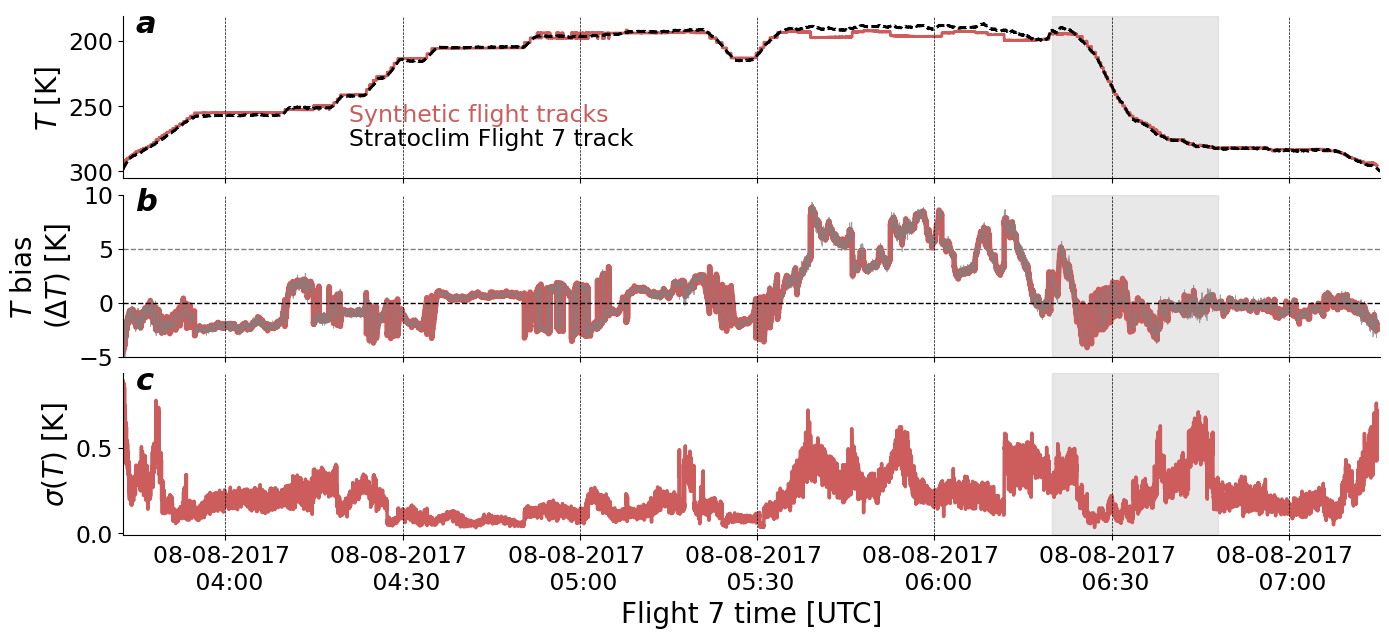

In [9]:
fs = 17
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14,6.5))
let = ['a', 'b', 'c']#, 'd', 'e']
for a, l, i in zip(ax, let, np.arange(3)):
    a.set_xlim( [t.min(), t.max()] )
    a.axvspan( np.datetime64('2017-08-08T06:20'), np.datetime64('2017-08-08T06:48'), color='lightgray', alpha=0.5 )
    sexy_axes(a, fs=fs, r=False)
    a.text(0.01, 0.9, l, weight='bold', style='italic', fontsize=fs+5, transform=a.transAxes)
    if i < 2:
        a.set_xticklabels([])
        
Tm = np.nanmean( T, axis=1 )
Tstd = np.nanstd( T, axis=1 )
Pm = np.nanmean( P, axis=1 )

ax[0].plot(t, Tm, color='indianred', lw=2)
ax[0].plot(t_Stratoclim, T_Stratoclim, color='k', lw=2, ls='--')
ax[0].set_ylabel(r'$T$ [K]', fontsize=fs+3)
ax[0].invert_yaxis()
ax[0].text(0.18, 0.2, 'Stratoclim Flight 7 track', fontsize=fs, transform=ax[0].transAxes)
ax[0].text(0.18, 0.35, 'Synthetic flight tracks', fontsize=fs, color='indianred', transform=ax[0].transAxes)

ax[1].plot(t, Tm - T_Stratoclim, color='indianred', linewidth=4)
ax[1].plot(t, best_traj, color='gray', lw=0.5, alpha=0.75)
ax[1].axhline( y=5, color='gray', ls='--', lw=1 )
ax[1].axhline( y=0, color='k', ls='--', lw=1 )
ax[1].set_ylabel(r'$T$ bias '
                 '\n'
                 '($\Delta T$) [K]', fontsize=fs+3)
ax[1].set_ylim([-5, 10])

ax[2].plot(t, Tstd, color='indianred', linewidth=2.5)
ax[2].set_ylabel(r'$\sigma(T)$ [K]', fontsize=fs+3)
ax[2].set_xticklabels(['08-08-2017 \n 04:00', '08-08-2017 \n 04:30','08-08-2017 \n 05:00','08-08-2017 \n 05:30',
    '08-08-2017 \n 06:00','08-08-2017 \n 06:30','08-08-2017 \n 07:00'])
ax[2].set_xlabel('Flight 7 time [UTC]', fontsize=fs+3)

for xtick in ax[2].get_xticks():
    for a in ax:
        a.axvline(x=xtick, color='k', ls='--', lw=0.5)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
fig.savefig('output/syn-flight-track-temperature.pdf',bbox_inches='tight')
plt.show()

# Figure 3: Temperature profile comparisons

In [25]:
# Which set of trajectory statistics do you want to open?
tag = '_E'  # E = 'extract', default 20 synthetic trajectories
#tag = '_E2' # Second (or third) set of 20 synthetic trajectories to test reproducibility
#tag = '_C' # C = 'collocate', minimize the Euclidean distance between sim and obs values
#tag = '_full' # Statistics over the full Flight 7 track

bd = '/groups/sylvia/UTLS-profiles/output/'
stats = []
for s in sim_list: 
    ds = xr.open_dataset( bd + 'ICON_synthetic_trajs_stats_' + s + tag + '.nc' )
    stats.append( ds )

plev = ds.pressure

In [26]:
min_alt = 5000
max_alt = 22000
icon_sz = 50
    
# Time range from Lee et al. 2019 (6:20-6:48 UTC)    
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)

# Full Flight 7 statistics
#time0 = datetime(2017, 8, 8, 4, 0)
#timef = datetime(2017, 8, 8, 7, 15)

In [27]:
# Suppress warnings about levels where there are no data
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
warnings.filterwarnings("ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")

# Read in-situ data
p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )

# Bin the in-situ data by pressure levels from the simulation
bins_sims, temp_SC_stats, theta_SC_stats, _, _, _, _ = \
    bin_flighttrack_general( plev.values, p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish )

In [28]:
# Reanalysis data
bd = '/groups/sylvia/UTLS-profiles/obs/'
era5_data = xr.open_dataset( bd + 'ERA5/2017-08-08-ERA5-vertical-profiles.nc' )

# Extract temperature and average it over the whole box
era5_temperature = era5_data.t.mean( dim=['latitude', 'longitude', 'valid_time'] )

In [29]:
# MLS data
filename = 'MLS/MLS-Aura_L2GP-Temperature_v05-01-c01_2017d220.he5'
with h5py.File( bd + filename, 'r' ) as f:
    mls_temperature = f['HDFEOS/SWATHS/Temperature/Data Fields/Temperature'][:]  # (3495, 55)
    lat = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Latitude'][:] # (3495, )
    lon = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Longitude'][:] # (3495, )
    mls_pressure1 = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Pressure'][:] # (55, )

# Filter for temperature and qv data where lat and lon fall within the box
mask = ( (lon >= 80) & (lon <= 90) & (lat >= 19) & (lat <=30) )
# If I would take mask_small, I get the 0th element when I take mask
#mask_small = ( (lon >= 83) & (lon <= 90) & (lat >= 25) & (lat <=30) )
mls_temperature_filtered = mls_temperature[mask, :]
print( mls_temperature_filtered.shape )

(8, 55)


In [30]:
# Sonde data
#sonde_id = [ '42182', '42867', '42089' ]
sonde_id = [ '42379', '42492', '42701', '42867', '42809', '42361' ]
sonde_list_temperature = []
sonde_list_pressure = []
for i in sonde_id:
    fi = bd + 'Sonde/Sonde-' + i + '-20170808T00.txt'
    df_raw = pd.read_csv( fi, sep='\s+', header=None, engine='python' )
    
    # Use the first row of text as column headers
    new_columns = [f"{var} [{unit}]" for var, unit in zip(df_raw.iloc[0], df_raw.iloc[1])]
    df_raw.columns = new_columns
    df_clean = df_raw.drop(index=[0, 1]).reset_index(drop=True).astype(float)

    # Append the temperature, qv, and pressure to sonde_list_temperature
    sonde_list_temperature.append( df_clean['TEMP [C]'].values + 273 )
    p = df_clean['PRES [hPa]'].values
    sonde_list_pressure.append( p )

In [31]:
# Create mean sonde data also by interpolating to a set of reference pressures across all sites
interpolated_temperatures = []
ref_pressure = sonde_list_pressure[0]
for p, t in zip(sonde_list_pressure, sonde_list_temperature):
    sort_idx = np.argsort(p)[::-1]
    p_sorted = p[sort_idx]
    t_sorted = t[sort_idx]

    f_interp = interp1d( p_sorted, t_sorted, kind='linear', bounds_error=False, fill_value=np.nan )
    interp_t = f_interp( ref_pressure )
    interpolated_temperatures.append( interp_t )

In [21]:
# Simulation data averaged over the whole domain, not just the flight track
sim_ds = xr.open_dataset( '/groups/sylvia/UTLS-profiles/output/mean-T-qv-profiles.nc' )

In [32]:
# Interpolate the in-situ data to the MLS, reanalysis, and sonde levels
# Factor of 100 converts from hPa to Pa
_, temp_SC_mls, _, _, _, _, _ = \
    bin_flighttrack_general( np.flip(mls_pressure1)*100, p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish )

# Flip back to the same direction as mls_pressure1
temp_SC_mls = np.flip(temp_SC_mls, axis=1)

_, temp_SC_era, _, _, _, _, _ = \
    bin_flighttrack_general( np.flip(era5_data.pressure_level.values)*100, p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish )
temp_SC_era = np.flip(temp_SC_era, axis=1)

_, temp_SC_sonde, _, _, _, _, _ = \
    bin_flighttrack_general( np.flip(ref_pressure)*100, p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish )
temp_SC_sonde = np.flip(temp_SC_sonde, axis=1)

# Apply the MLS averging kernel to the regridded StratoClim output
temp_SC_mls_update = mls_regrid_kernel( "Temperature", temp_SC_mls[0], mls_temperature_filtered[0] )

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


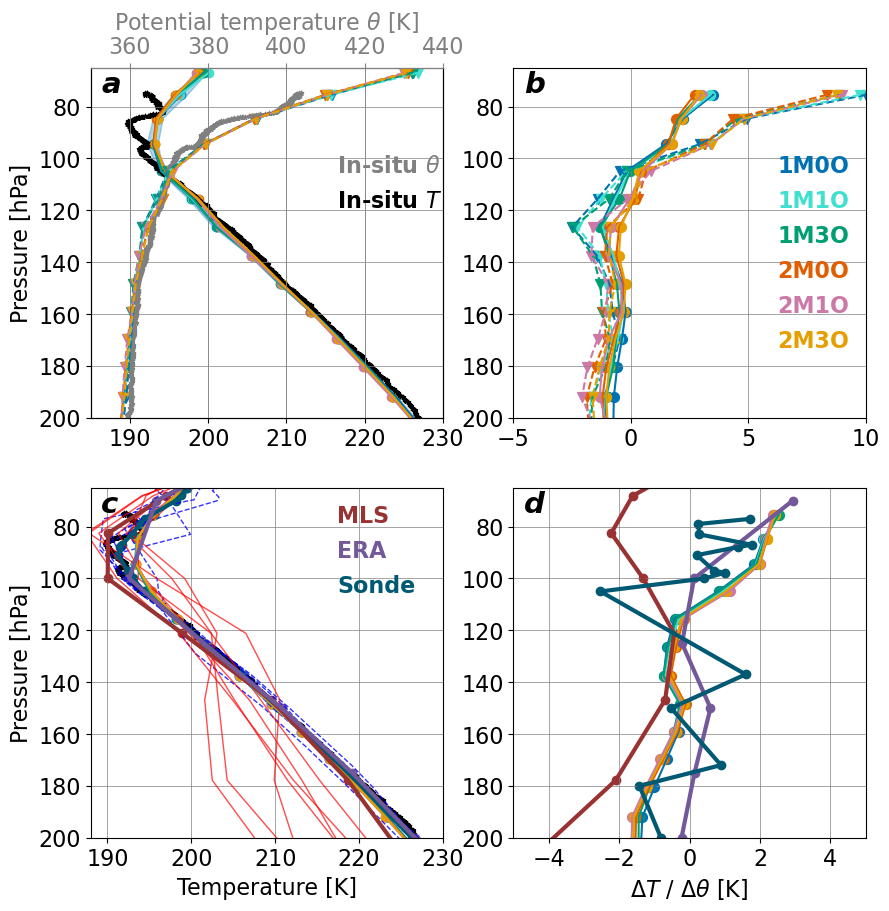

In [33]:
lw = 3
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax0 = ax[0,0].twiny()
axs = list(ax.flatten())
axs.append( ax0 )
let = ['a','b','c','d']
datasets = ['MLS', 'ERA', 'Sonde']

# Other plotting parameters
icon_lw = 1.5
icon_alfa = 1
fs = 16
yval = plev/100 # Convert Pa -> hPa

# Specify whether to compare means (l = 0) or medians (l = 1)
k = 'mean'; l = 0

# Axis limits specified
for i, a in enumerate(axs):
    a.set_ylim([65, 200])
    a.tick_params('both',labelsize=fs)
    a.invert_yaxis()
    if i != 4:
        a.text( 0.03, 0.93, let[i], fontsize=fs+5, style='italic', weight='bold', transform=a.transAxes )
    a.grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
    if i %2 == 0:
        a.set_ylabel( 'Pressure [hPa]', fontsize=fs )
ax[0,1].set_xlim([-5, 10])
ax[1,1].set_xlim([-5, 5])

# Align grid lines on PANELS A and C
ax[0,0].set_xlim([185, 230])
ax[1,0].set_xlim([180, 230])
ax0.set_xlim([2*185 - 20, 2*230 - 20])
xticks_ax = [190, 200, 210, 220, 230]
xticks_ax0 = [2*x - 20 for x in xticks_ax]
ax[0,0].set_xticks(xticks_ax)
ax[1,0].set_xticks(xticks_ax)
ax0.set_xticks(xticks_ax0)

# Set matching ticks and gridlines
xticks_ax = [190, 200, 210, 220]
xticks_ax0 = [2*x - 20 for x in xticks_ax] 

# PANEL A: Mean (or median) temperature over all trajectories
tm = np.nanmean( stats[0]['temp_'+k], axis=1 )
tstd = np.nanmean( stats[0]['temp_std'], axis=1 )
# Shade the area for +/- a standard deviation for the first simulation
ax[0,0].fill_betweenx( y=yval, x1=tm-tstd, x2=tm+tstd, alpha=0.3, color=farbe['1M0O'] )
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    tm = np.nanmean( stats[i]['temp_'+k], axis=1 )
    ax[0,0].scatter( tm, yval, color=farbe[sl] )
    ax[0,0].plot( tm, yval, lw=icon_lw, color=farbe[sl] )
ax[0,0].scatter(temp, p3, color='k', s=10, marker='*')

# PANEL A: Potential temperature 
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    thetam = np.nanmean( stats[i]['theta_'+k], axis=1 )
    thetastd = np.nanmean( stats[i]['theta_std'], axis=1 )
    ax0.scatter( thetam, yval, marker='v', s=icon_sz, color=farbe[sl] )
    ax0.plot( thetam, yval, lw=icon_lw, ls='--', color=farbe[sl] )
ax0.scatter(theta, p3, color='gray', s=10, marker='*')
ax0.set_xlabel(r'Potential temperature $\theta$ [K]', fontsize=fs, color='gray')
ax0.spines['top'].set_color('gray')
ax0.tick_params(axis='x',colors='gray')
ax0.text(0.7, 0.7, r'In-situ $\theta$', fontsize=fs, weight='bold', color='gray', transform=ax0.transAxes)
ax0.text(0.7, 0.6, r'In-situ $T$', fontsize=fs, weight='bold', color='black', transform=ax0.transAxes)

# PANEL B: Temperature and theta anomalies
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    tm = np.nanmean( stats[i]['temp_'+k], axis=1 )
    thetam = np.nanmean( stats[i]['theta_'+k], axis=1 )
    ax[0,1].scatter( tm-temp_SC_stats[l], yval, s=icon_sz, alpha=icon_alfa, color=farbe[sl] )
    ax[0,1].plot( tm-temp_SC_stats[l], yval, lw=icon_lw, color=farbe[sl] )
    ax[0,1].text(0.75, 0.7-i*0.1, sl, fontsize=fs, weight='bold', color=farbe[sl], transform=ax[0,1].transAxes)
    ax[0,1].scatter( thetam-theta_SC_stats[l], yval, s=icon_sz, marker='v', alpha=icon_alfa, color=farbe[sl] )
    ax[0,1].plot( thetam-theta_SC_stats[l], yval, lw=icon_lw, ls='--', color=farbe[sl] )

# PANEL C: Temperature profiles from other data sources
for j in range(len(sonde_id)):
    ax[1,0].plot( sonde_list_temperature[j], sonde_list_pressure[j], lw=1, alpha=0.8, color='blue', ls='--' )
for i in range(8):
    ax[1,0].plot( mls_temperature_filtered[i], mls_pressure1, lw=1, alpha=0.7, color='red' )
    
mean_sonde_temperature = np.nanmean( interpolated_temperatures, axis=0 )
mean_sonde_pressure = ref_pressure
ax[1,0].scatter( temp, p3, color='k', s=10, marker='*' )
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    tm = sim_ds.sel(simulation=sl)['mean_T']
    ax[1,0].scatter( tm, yval, color=farbe[sl] )
    ax[1,0].plot( tm, yval, lw=icon_lw, color=farbe[sl] )
ax[1,0].scatter( mean_sonde_temperature, mean_sonde_pressure, color=farbe['Sonde'] )
ax[1,0].plot( mean_sonde_temperature, mean_sonde_pressure, lw=lw, color=farbe['Sonde'] )
# Highlight only the MLS data geographically closest to the Flight 7 measurements
ax[1,0].scatter( mls_temperature_filtered[0], mls_pressure1, color=farbe['MLS'] )
ax[1,0].plot( mls_temperature_filtered[0], mls_pressure1, lw=lw, color=farbe['MLS'] )
ax[1,0].scatter( era5_temperature, era5_data.pressure_level, color=farbe['ERA'] )
ax[1,0].plot( era5_temperature, era5_data.pressure_level, lw=lw, color=farbe['ERA'] )
ax[1,0].set_xlim( [188, 230] )
ax[1,0].set_xlabel( 'Temperature [K]', fontsize=fs )
for j, dd in enumerate(datasets):
    ax[1,0].text( 0.7, 0.9-j*0.1, dd, color=farbe[dd], weight='bold', fontsize=fs, transform=ax[1,0].transAxes )

# PANEL D: Temperature anomalies from other data sources
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    tm = sim_ds.sel(simulation=sl)['mean_T']
    ax[1,1].scatter( tm-temp_SC_stats[l], yval, s=icon_sz, alpha=icon_alfa, color=farbe[sl] )
    ax[1,1].plot( tm-temp_SC_stats[l], yval, lw=icon_lw, color=farbe[sl] )
# Take the differences to MLS data only using the obs closest to the Flight 7 measurements
#ax[1,1].scatter( mls_temperature_filtered[0]-temp_SC_mls[0], mls_pressure1, color=farbe['MLS'] )
#ax[1,1].plot( mls_temperature_filtered[0]-temp_SC_mls[0], mls_pressure1, lw=lw, color=farbe['MLS'] )
ax[1,1].scatter( mls_temperature_filtered[0]-temp_SC_mls_update, mls_pressure1, color=farbe['MLS'] )
ax[1,1].plot( mls_temperature_filtered[0]-temp_SC_mls_update, mls_pressure1, lw=lw, color=farbe['MLS'] )
ax[1,1].scatter( era5_temperature-temp_SC_era[0], era5_data.pressure_level, color=farbe['ERA'] )
ax[1,1].plot( era5_temperature-temp_SC_era[0], era5_data.pressure_level, lw=lw, color=farbe['ERA'] )
ax[1,1].scatter( mean_sonde_temperature-temp_SC_sonde[0], mean_sonde_pressure, color=farbe['Sonde'] )
ax[1,1].plot( mean_sonde_temperature-temp_SC_sonde[0], mean_sonde_pressure, lw=lw, color=farbe['Sonde'] )
ax[1,1].set_xlabel(r'$\Delta T$ / $\Delta\theta$ [K]', fontsize=fs)

#fig.savefig( 'output/temperature-profile-comparison' + tag + '.pdf', bbox_inches='tight' )
plt.show()

# Figure 4: Specific humidity along the flight tracks

In [14]:
basedir = '/groups/sylvia/UTLS-profiles/output/'
syn_traj = xr.open_dataset(basedir + 'ICON_synthetic_trajs_1M0O_E.nc')
qv_sim = syn_traj.qv.values * conv * 10**6
t = syn_traj.time.values # DataArray of length 12770

# Read in-situ data
daten = xr.open_dataset('/groups/sylvia/UTLS-profiles/obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
qv_Stratoclim1 = daten['BEST:H2O_enh']
qv_Stratoclim2 = daten['BEST:H2O_gas']
t_Stratoclim = daten['time']

In [15]:
# Identify the best trajectory
jbest = best_track( syn_traj.qv * conv * 10**6, qv_Stratoclim2 )
print( jbest )
qvdiff = (qv_sim - qv_Stratoclim2.values[:, np.newaxis])/qv_Stratoclim2.values[:, np.newaxis] * 100
best_traj = qvdiff[:, jbest]

6


/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


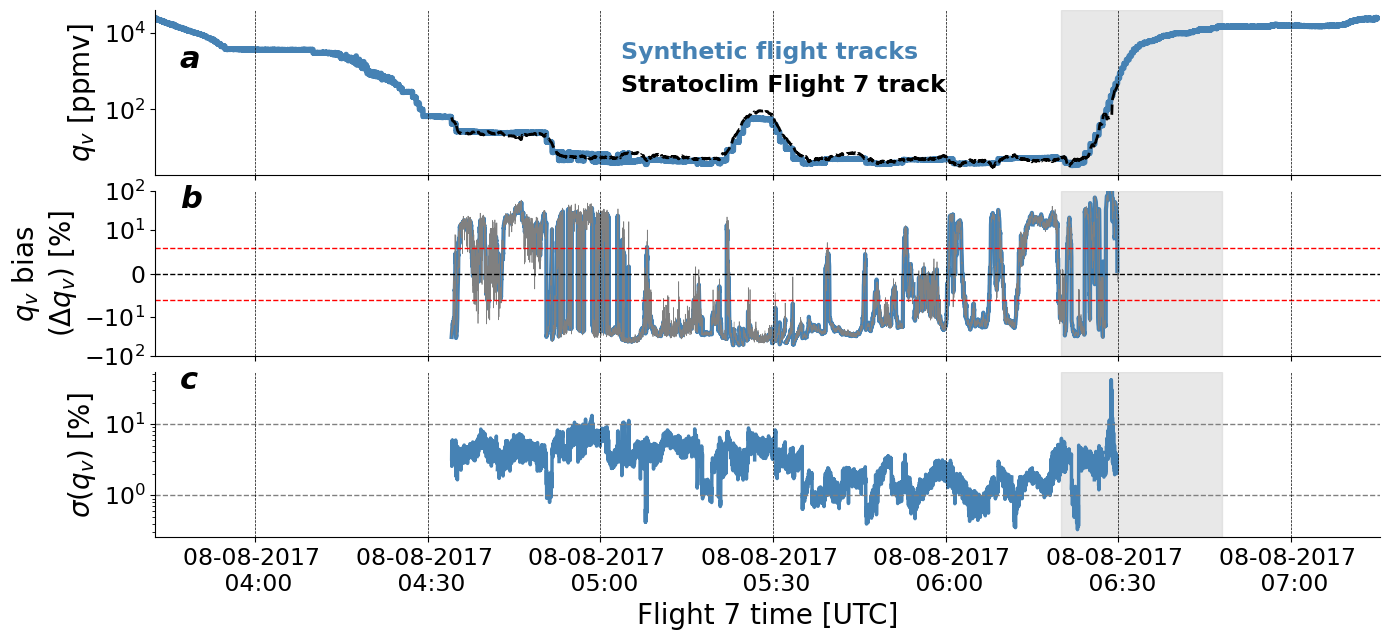

In [16]:
fs = 17
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14,6.5))
let = ['a', 'b', 'c']
for a, l, i in zip(ax, let, np.arange(6)):
    a.set_xlim( [t.min(), t.max()] )
    a.axvspan( np.datetime64('2017-08-08T06:20'), np.datetime64('2017-08-08T06:48'), color='lightgray', alpha=0.5 )
    sexy_axes(a, fs=fs, r=False)
    if i == 0:
        a.text(0.02, 0.65, l, weight='bold', style='italic', fontsize=fs+5, transform=a.transAxes)
    else:
       a.text(0.02, 0.9, l, weight='bold', style='italic', fontsize=fs+5, transform=a.transAxes) 
    if i < 2:
        a.set_xticklabels([])
        
qvm = np.nanmean( qv_sim, axis=1 )
qvstd = np.nanstd( qv_sim, axis=1 )

ax[0].plot(t, qvm, color='steelblue', lw=4)
ax[0].plot(t_Stratoclim, qv_Stratoclim2, color='k', lw=2, ls='--')
ax[0].set_yscale( 'log' )
ax[0].set_ylabel(r'$q_v$ [ppmv]', fontsize=fs+3)
ax[0].text(0.38, 0.5, 'Stratoclim Flight 7 track', weight='bold', fontsize=fs, transform=ax[0].transAxes)
ax[0].text(0.38, 0.7, 'Synthetic flight tracks',  weight='bold', fontsize=fs, color='steelblue', transform=ax[0].transAxes)

ax[1].plot(t, (qvm - qv_Stratoclim2)/qv_Stratoclim2 * 100, color='steelblue', linewidth=3)
ax[1].plot(t, best_traj, color='gray', lw=0.5)
ax[1].axhline( y=0, color='k', ls='--', lw=1 )
ax[1].axhline( y=6, color='red', ls='--', lw=1 )
ax[1].axhline( y=-6, color='red', ls='--', lw=1 )
ax[1].set_ylabel(r'$q_v$ bias'
                 '\n'
                 '($\Delta q_v$) [%]', fontsize=fs+3)
ax[1].set_yscale( 'symlog', linthresh=1e1 )
ax[1].set_ylim( [-100, 100] )

ax[2].plot(t, qvstd/qv_Stratoclim2 * 100, color='steelblue', linewidth=2.5)
ax[2].set_ylabel(r'$\sigma(q_v)$ [%]', fontsize=fs+3)
ax[2].set_yscale( 'log' )
ax[2].axhline( y=1, color='gray', ls='--', lw=1 )
ax[2].axhline( y=10, color='gray', ls='--', lw=1 )
ax[2].set_xticklabels(['08-08-2017 \n 04:00', '08-08-2017 \n 04:30','08-08-2017 \n 05:00','08-08-2017 \n 05:30',
    '08-08-2017 \n 06:00','08-08-2017 \n 06:30','08-08-2017 \n 07:00'])
ax[2].set_xlabel('Flight 7 time [UTC]', fontsize=fs+3)

for xtick in ax[2].get_xticks():
    for a in ax:
        a.axvline(x=xtick, color='k', ls='--', lw=0.5)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
fig.savefig('output/syn-flight-track-qv.pdf',bbox_inches='tight')
plt.show()

# Figure 5: Specific humidity profile comparisons

In [4]:
# Which set of trajectory statistics do you want to open?
tag = '_E'  # E = 'extract', default 20 synthetic trajectories
#tag = '_E2' # Second (or third) set of 20 synthetic trajectories to test reproducibility
#tag = '_C' # C = 'collocate', minimize the Euclidean distance between sim and obs values
#tag = '_full' # Statistics over the full Flight 7 track

bd = '/groups/sylvia/UTLS-profiles/output/'
stats = []
for s in sim_list: 
    ds = xr.open_dataset( bd + 'ICON_synthetic_trajs_stats_' + s + tag + '.nc' )
    stats.append( ds )

plev = ds.pressure

In [5]:
# Time range from Lee et al. 2019 (6:20-6:48 UTC)    
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)

# Full Flight 7 statistics
#time0 = datetime(2017, 8, 8, 4, 0)
#timef = datetime(2017, 8, 8, 7, 15)

# Suppress warnings about levels where there are no data
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
warnings.filterwarnings("ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")

# Read in-situ data
p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )

# Bin the in-situ data by pressure levels from the simulation
bins_sims, _, _, qv_flash_SC_stats, qv_fish_SC_stats, _, _ = \
    bin_flighttrack_general( plev.values, p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish )

In [6]:
# Reanalysis data
bd = '/groups/sylvia/UTLS-profiles/obs/'
era5_data = xr.open_dataset( bd + 'ERA5/2017-08-08-ERA5-vertical-profiles.nc' )

# Extract specific humidity, convert it to ppmv, and average it over the whole box
mw_dryair = 28.97*1000    # kg air (mol air)-1
mw_watvap = 18.02*1000    # kg wv (mol wv)-1
conv = mw_dryair / mw_watvap
era5_qv = era5_data.q.mean( dim=['latitude', 'longitude', 'valid_time'] ) * conv * 10**6

In [7]:
# MLS data
filename = 'MLS/MLS-Aura_L2GP-H2O_v05-01-c01_2017d220.he5'
with h5py.File( bd + filename, 'r' ) as f:
    mls_h2o = f['HDFEOS/SWATHS/H2O/Data Fields/H2O'][:]  # (3495, 55)
    #print( f['HDFEOS/SWATHS/H2O/Data Fields/H2O'].attrs['Units'] ) # Return units of H2O
    lat = f['HDFEOS/SWATHS/H2O/Geolocation Fields/Latitude'][:] # (3495, )
    lon = f['HDFEOS/SWATHS/H2O/Geolocation Fields/Longitude'][:] # (3495, )
    mls_pressure2 = f['HDFEOS/SWATHS/H2O/Geolocation Fields/Pressure'][:] # (55, )

# Filter for temperature and qv data where lat and lon fall within the box
mask = ( (lon >= 80) & (lon <= 90) & (lat >= 19) & (lat <=30) )
# If I would take mask_small, I get the 0th element when I take mask
#mask_small = ( (lon >= 83) & (lon <= 90) & (lat >= 25) & (lat <=30) )
mls_h2o_filtered = mls_h2o[mask, :] * 10**6  # convert from a unitless volumetric mixing ratio to ppmv

In [8]:
# Sonde data
#sonde_id = [ '42182', '42867', '42089' ]
sonde_list_pressure = []
sonde_id = [ '42379', '42492', '42701', '42867', '42809', '42361' ]
sonde_list_qv = []
for i in sonde_id:
    fi = bd + 'Sonde/Sonde-' + i + '-20170808T00.txt'
    df_raw = pd.read_csv( fi, sep='\s+', header=None, engine='python' )
    
    # Use the first row of text as column headers
    new_columns = [f"{var} [{unit}]" for var, unit in zip(df_raw.iloc[0], df_raw.iloc[1])]
    df_raw.columns = new_columns
    df_clean = df_raw.drop(index=[0, 1]).reset_index(drop=True).astype(float)

    # Append the temperature, qv, and pressure to sonde_list_temperature
    p = df_clean['PRES [hPa]'].values
    sonde_list_pressure.append( p )
    qv_clean = df_clean['MIXR [g/kg]'].values * conv * 10**3
    sonde_list_qv.append( np.where( p > 120, qv_clean, np.nan) ) # not sure of rationale for the 120 threshold here

In [9]:
# Create mean sonde data also by interpolating to a set of reference pressures across all sites
interpolated_qv = []
ref_pressure = sonde_list_pressure[0]
for p, q in zip(sonde_list_pressure, sonde_list_qv):
    sort_idx = np.argsort(p)[::-1]
    p_sorted = p[sort_idx]
    q_sorted = q[sort_idx]

    f_interp = interp1d( p_sorted, q_sorted, kind='linear', bounds_error=False, fill_value=np.nan )
    interp_q = f_interp( ref_pressure )
    interpolated_qv.append( interp_q )

In [10]:
# Simulation data averaged over the whole domain, not just the flight track
sim_ds = xr.open_dataset( '/groups/sylvia/UTLS-profiles/output/mean-T-qv-profiles.nc' )

In [11]:
# Interpolate the in-situ data to the MLS, reanalysis, and sonde levels
# Factor of 100 converts from hPa to Pa
_, _, _, qv_flash_SC_mls, _, _, _ = \
    bin_flighttrack_general( np.flip(mls_pressure2)*100, p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish )

# Flip back to the same direction as mls_pressure1
qv_flash_SC_mls = np.flip(qv_flash_SC_mls, axis=1)

_, _, _, qv_flash_SC_era, _, _, _ = \
    bin_flighttrack_general( np.flip(era5_data.pressure_level.values)*100, p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish )
qv_flash_SC_era = np.flip(qv_flash_SC_era, axis=1)

_, _, _, qv_flash_SC_sonde, _, _, _ = \
    bin_flighttrack_general( np.flip(ref_pressure)*100, p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish )
qv_flash_SC_sonde = np.flip(qv_flash_SC_sonde, axis=1)

# Apply the MLS averging kernel to the regridded StratoClim output
qv_flash_SC_mls_update = mls_regrid_kernel( "H2O", qv_flash_SC_mls[0], mls_h2o_filtered[0] )
print( (mls_h2o_filtered[0] - qv_flash_SC_mls_update)/qv_flash_SC_mls_update * 100 )

[-1.36338598e-14 -3.98417326e-14 -1.57743197e-14  2.67873938e-14
  0.00000000e+00 -4.16108571e-14 -1.76581708e-02 -2.80561146e+00
 -8.50803884e+00  7.18961609e+00  1.86748855e+01 -1.00739393e+01
 -2.04391704e+01 -8.45077213e+00  3.37127648e+00  3.04036128e+00
 -1.48062399e+00 -1.29865903e+00  6.88833473e-01  6.48860912e-01
 -2.96885378e-01 -3.63886382e-01  1.64542308e-01  1.72053105e-01
 -5.35043878e-02 -7.55932665e-02 -1.69992124e-03  4.28390263e-02
  3.83262351e-02 -3.42250691e-02 -3.24086534e-02  3.18673012e-02
  3.54005037e-02 -1.85518891e-02 -8.74766674e-03  1.68177405e-03
  1.36187314e-02 -2.41981583e-03  5.96510550e-03  2.16875916e-03
  4.60191269e-03  1.34913651e-03  4.27257421e-03  7.90048862e-03
 -1.69056823e-03 -2.90322794e-04  2.61566637e-03  1.01910243e-03
  2.34518673e-04 -1.18586295e-05  0.00000000e+00  1.79656496e-14
  1.79656496e-14  1.79656496e-14  1.79656496e-14]


/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


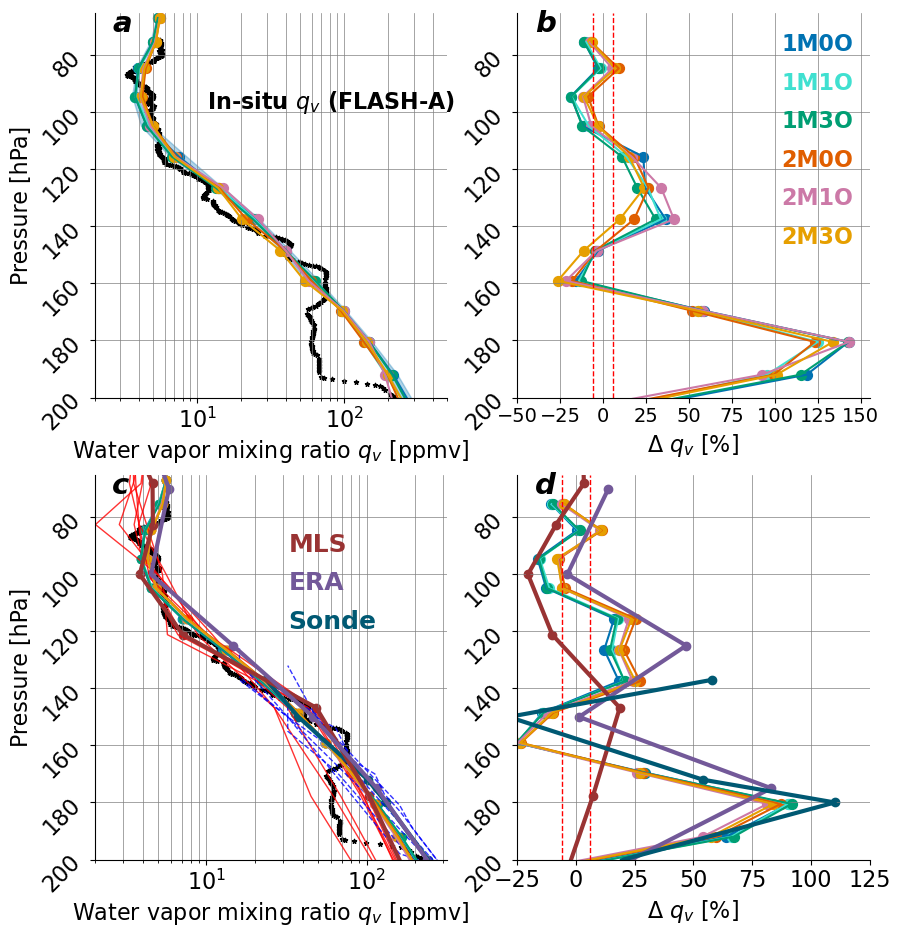

In [17]:
lw = 3
fs = 14
yval = plev/100 # Convert Pa -> hPa

# Other plotting parameters
icon_lw = 1.5
icon_sz = 50
icon_alfa = 1
fs = 16
let = ['a','b','c','d']
datasets = ['MLS', 'ERA', 'Sonde']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 11))

# Specify whether to compare means (l = 0) or medians (l = 1)
k = 'mean'; l = 0

for i, a in enumerate(ax.flatten()):
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    a.invert_yaxis()
    a.set_ylim( [200, 65] )
    a.tick_params( labelsize=fs )
    a.tick_params( axis='y', labelrotation=45 )
    a.text( 0.05, 0.95, let[i], fontsize=fs+5, style='italic', weight='bold', transform=a.transAxes )
    a.grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
    if i %2 == 0:
        a.set_ylabel( 'Pressure [hPa]', fontsize=fs )
ax[0,0].set_xlim([2, 500])
ax[0,1].set_xlim([-50, 155])
ax[0,1].set_xticks([-50, -25, 0, 25, 50, 75, 100, 125, 150])
ax[0,1].tick_params(axis='x', labelsize=fs-2)
ax[1,1].set_xlim([-25, 125])
ax[1,1].set_xticks([-25, 0, 25, 50, 75, 100, 125])

# PANEL A: Mean (or median) specific humidity across all trajectories
qvm = np.nanmean( stats[0]['qv_'+k], axis=1 )
qvstd = np.nanmean( stats[0]['qv_std'], axis=1 )
ax[0,0].fill_betweenx( y=yval, x1=qvm-qvstd, x2=qvm+qvstd, alpha=0.3, color=farbe['1M0O'] )
ax[0,0].scatter( qv_flash, p1, color='k', s=10, marker='*')
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    qvm = np.nanmean( stats[i]['qv_'+k], axis=1 )
    ax[0,0].scatter( qvm, yval, s=icon_sz, color=farbe[sl] )
    ax[0,0].plot( qvm, yval, lw=icon_lw, color=farbe[sl] )
ax[0,0].text(0.32, 0.75, 'In-situ $q_v$ (FLASH-A)', fontsize=fs, weight='bold', transform=ax[0,0].transAxes)
ax[0,0].set_xlabel('Water vapor mixing ratio $q_v$ [ppmv]',fontsize=fs)
ax[0,0].set_ylabel('Pressure [hPa]',fontsize=fs)
ax[0,0].set_xscale('log')

# PANEL B: Specific humidity anomalies
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    qvm = np.nanmean( stats[i]['qv_'+k], axis=1 )
    ax[0,1].scatter( (qvm-qv_flash_SC_stats[l])/qv_flash_SC_stats[l]*100, yval, s=icon_sz, alpha=icon_alfa, color=farbe[sl] )
    ax[0,1].plot( (qvm-qv_flash_SC_stats[l])/qv_flash_SC_stats[l]*100, yval, lw=icon_lw, color=farbe[sl] )
    ax[0,1].text(0.75, 0.9-i*0.1, sl, fontsize=fs, weight='bold', color=farbe[sl], transform=ax[0,1].transAxes)
ax[0,1].axvline( x=-6, color='r', lw=1, ls='--' )
ax[0,1].axvline( x=6, color='r', lw=1, ls='--' )
ax[0,1].set_xlabel(r'$\Delta$ $q_v$ [%]', fontsize=fs)

# PANEL C: Specific humidity profiles from other data sources
for i in range(8):
    ax[1,0].plot( mls_h2o_filtered[i], mls_pressure2, lw=1, alpha=0.8, color='red' )
for j in range(len(sonde_id)):
    ax[1,0].plot( sonde_list_qv[j], sonde_list_pressure[j], lw=1, alpha=0.8, color='blue', ls='--' )
    
mean_sonde_pressure = ref_pressure
mean_sonde_qv = np.nanmean( interpolated_qv, axis=0 )
ax[1,0].scatter( qv_flash, p1, color='k', s=10, marker='*')
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    qvm = sim_ds.sel(simulation=sl)['mean_qv'] * conv * 10**6
    ax[1,0].scatter( qvm, yval, color=farbe[sl] )
    ax[1,0].plot( qvm, yval, lw=icon_lw, color=farbe[sl] )
ax[1,0].scatter( mean_sonde_qv, mean_sonde_pressure, color=farbe['Sonde'] )
ax[1,0].plot( mean_sonde_qv, mean_sonde_pressure, lw=lw, color=farbe['Sonde'] )
# Highlight only the MLS data geographically closest to the Flight 7 measurements
ax[1,0].scatter( mls_h2o_filtered[0], mls_pressure2, color=farbe['MLS'] )
ax[1,0].plot( mls_h2o_filtered[0], mls_pressure2, lw=lw, color=farbe['MLS'] )
ax[1,0].scatter( era5_qv, era5_data.pressure_level, color=farbe['ERA']  )
ax[1,0].plot( era5_qv, era5_data.pressure_level, lw=lw, color=farbe['ERA'] )
ax[1,0].set_xscale( 'log' )
ax[1,0].set_xlim( [2, 10**2.5] )
ax[1,0].set_xlabel( r'Water vapor mixing ratio $q_v$ [ppmv]', fontsize=fs )
for j, dd in enumerate(datasets):
    ax[1,0].text( 0.55, 0.8-j*0.1, dd, color=farbe[dd], weight='bold', fontsize=fs+2, transform=ax[1,0].transAxes )

# PANEL D: Specific humidity anomalies from other data sources
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    qvm = sim_ds.sel(simulation=sl)['mean_qv'] * conv * 10**6
    ax[1,1].scatter( (qvm-qv_flash_SC_stats[l])/qv_flash_SC_stats[l]*100, yval, s=icon_sz, alpha=icon_alfa, color=farbe[sl] )
    ax[1,1].plot((qvm-qv_flash_SC_stats[l])/qv_flash_SC_stats[l]*100, yval, lw=icon_lw, color=farbe[sl] )
# Take the differences to MLS data only using the obs closest to the Flight 7 measurements
ax[1,1].axvline( x=-6, color='r', lw=1, ls='--' )
ax[1,1].axvline( x=6, color='r', lw=1, ls='--' )
# No kernel correction
#ax[1,1].scatter( (mls_h2o_filtered[0]-qv_flash_SC_mls[0])/qv_flash_SC_mls[0]*100, mls_pressure2, color=farbe['MLS'] )
#ax[1,1].plot( (mls_h2o_filtered[0]-qv_flash_SC_mls[0])/qv_flash_SC_mls[0]*100, mls_pressure2, lw=lw, color=farbe['MLS'] )
ax[1,1].scatter( (mls_h2o_filtered[0]-qv_flash_SC_mls_update)/qv_flash_SC_mls_update*100, mls_pressure2, color=farbe['MLS'] )
ax[1,1].plot( (mls_h2o_filtered[0]-qv_flash_SC_mls_update)/qv_flash_SC_mls_update*100, mls_pressure2, lw=lw, color=farbe['MLS'] )
ax[1,1].scatter( (era5_qv-qv_flash_SC_era[l])/qv_flash_SC_era[l]*100, era5_data.pressure_level, color=farbe['ERA'] )
ax[1,1].plot( (era5_qv-qv_flash_SC_era[l])/qv_flash_SC_era[l]*100, era5_data.pressure_level, lw=lw, color=farbe['ERA'] )
ax[1,1].scatter( (mean_sonde_qv-qv_flash_SC_sonde[l])/qv_flash_SC_sonde[l]*100, mean_sonde_pressure, color=farbe['Sonde'] )
ax[1,1].plot( (mean_sonde_qv-qv_flash_SC_sonde[l])/qv_flash_SC_sonde[l]*100, mean_sonde_pressure, lw=lw, color=farbe['Sonde'] )
ax[1,1].set_xlabel(r'$\Delta$ $q_v$ [%]', fontsize=fs)

#fig.savefig( 'output/qv-profile-comparison' + tag + '.pdf', bbox_inches='tight' )
plt.show()

# Figure 6: Joint distribution of temperature and moisture biases

In [53]:
# Which set of synthetic trajectory files to read?
tag = '_E'  # E = 'extract', default 500 synthetic trajectories
#tag = '_E2' # Second (or third) set of 500 synthetic trajectories to test reproducibility
#tag = '_C' # C = 'collocate', minimize the Euclidean distance between sim and obs values
#tag = '_P' # P = 'pinpoint', find the closest numerical value to the obs within the sim
#tag = '_full' # Statistics over the full Flight 7 track

# Read in the synthetic trajectory files and save temperature and qv biases
bd = '/groups/sylvia/UTLS-profiles/output/'
bd2 = '/groups/sylvia/UTLS-profiles/obs/'
vals = np.zeros( (6, 2, 12770) )
#t_vals = np.zeros( (6, 2, 12770) )
#qv_vals = np.zeros( (6, 2, 12770) )
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    ds2 = xr.open_dataset( bd2 + 'stratoclim2017.geophysika.0808_1.filtered_per_sec.nc' )
    alt_obs = ds2['BEST:ALT']
    t_obs = ds2['BEST:TEMP']
    qv_obs = ds2['BEST:H2O_gas']
    
    ds = xr.open_dataset( bd + 'ICON_synthetic_trajs_' + sl + tag + '.nc' )
    t_sim = ds['temp'][:,0]
    qv_sim = ds['qv'][:,0] * conv * 10**6
    w_sim = ds['w'][:,0]
    
    # Filter only for UTLS values
    t_obs = xr.where( alt_obs > 14000, t_obs, np.nan )
    qv_obs = xr.where( alt_obs > 14000, qv_obs, np.nan )
    t_sim = xr.where( alt_obs > 14000, t_sim, np.nan )
    qv_sim = xr.where( alt_obs > 14000, qv_sim, np.nan )

    # Calculate biases in temperature and specific humidity
    vals[i,0] = (t_sim - t_obs)/t_obs*100
    #vals[i,0] = (t_sim - t_obs)
    vals[i,1] = (qv_sim - qv_obs)/qv_obs*100
    
    #t_vals[i,0] = t_sim
    #t_vals[i,1] = t_obs
    #qv_vals[i,0] = qv_sim
    #qv_vals[i,1] = qv_obs 

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


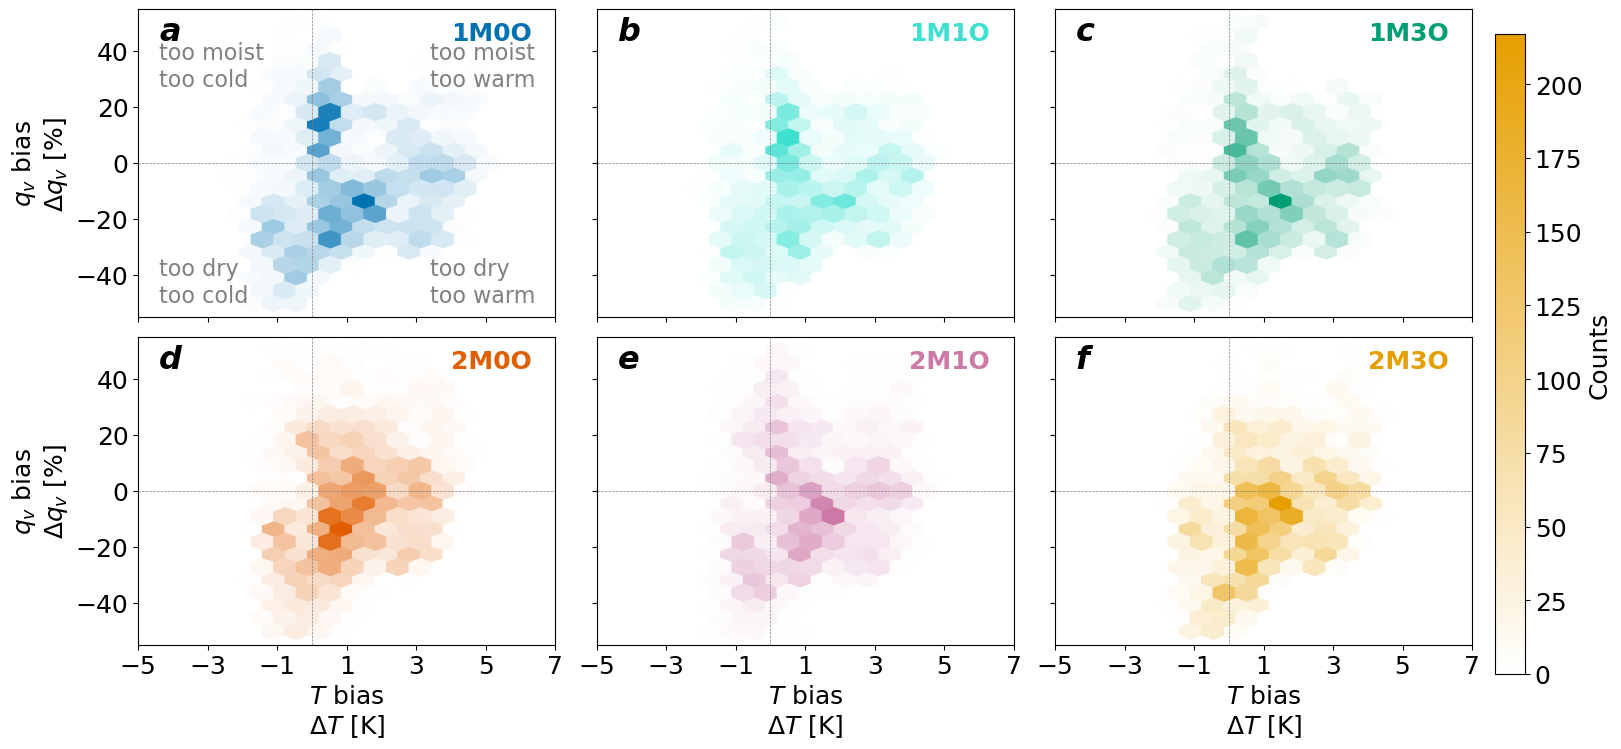

In [54]:
fs = 18
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
panel_labels = ['a','b','c','d','e','f']

for (idx, ax), sl in zip(enumerate(axs.flat), sim_list):
    # Create a contourf plot with the temperature and specific humidity biases
    cmap = LinearSegmentedColormap.from_list("custom_seq", ["white", farbe[sl]])
    hb = ax.hexbin( vals[idx,0], vals[idx,1], gridsize=20, extent=[-5, 8, -50, 50], cmap=cmap ) #[-5, 9, -60, 60]
    ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.tick_params(labelsize=fs)
    if idx % 3 == 0:
        ax.set_ylabel(r"$q_v$ bias"
                      "\n"
                      "$\Delta q_v$ [%]", fontsize=fs)
    if idx // 3 == 1:
        ax.set_xlabel(r"$T$ bias"
                      "\n"
                      "$\Delta T$ [K]", fontsize=fs)
    ax.text(0.05, 0.9, panel_labels[idx], transform=ax.transAxes, fontstyle='italic', fontsize=fs+5, fontweight='bold')
    ax.text(0.75, 0.9, sl, transform=ax.transAxes, fontsize=fs, color=farbe[sl], fontweight='bold')
    ax.set_xlim([-5,5])

axs[0,0].text( 0.7, 0.75, 'too moist \ntoo warm', color='gray', fontsize=fs-2, transform=axs[0,0].transAxes )
axs[0,0].text( 0.7, 0.05, 'too dry \ntoo warm', color='gray', fontsize=fs-2, transform=axs[0,0].transAxes )
axs[0,0].text( 0.05, 0.75, 'too moist \ntoo cold', color='gray', fontsize=fs-2, transform=axs[0,0].transAxes )
axs[0,0].text( 0.05, 0.05, 'too dry \ntoo cold', color='gray', fontsize=fs-2, transform=axs[0,0].transAxes )

for ax in axs.flat:
    #ax.set_xticks(np.arange(-5, 5, 1))
    ax.set_xticks(np.arange(-5, 9, 2))

# Create a single vertical colorbar spanning both rows of subplots
cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.8])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.set_label('Counts', fontsize=fs)
cbar.ax.tick_params(labelsize=fs)
plt.tight_layout(rect=[0, 0, 1, 0.95])

#fig.savefig( 'output/T-qv-joint-distributions' + tag + '.pdf', bbox_inches='tight' )
plt.show()

-1.4303241735420245 0.040912958449683116 1.2102983426260354
-53.8945799102787 -0.20554792153178567 63.86289379334243
-1.3723706442212298 -0.04040734633096622 1.1181528486917651
-49.399220078431185 -1.957048782740014 53.70657497198409
-1.3489236830830973 0.02930214562669433 1.3594208666077248
-57.79597925628304 1.5546340674849897 62.34414711980614
-1.6054150926871338 0.029097649155968183 2.016044085393876
-50.36257419421781 2.7532208435238283 64.00517047106851
-1.4179830999416638 0.06520799872696761 1.465364520174187
-74.0498848791041 -0.7758371735456844 41.603323105010205


/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


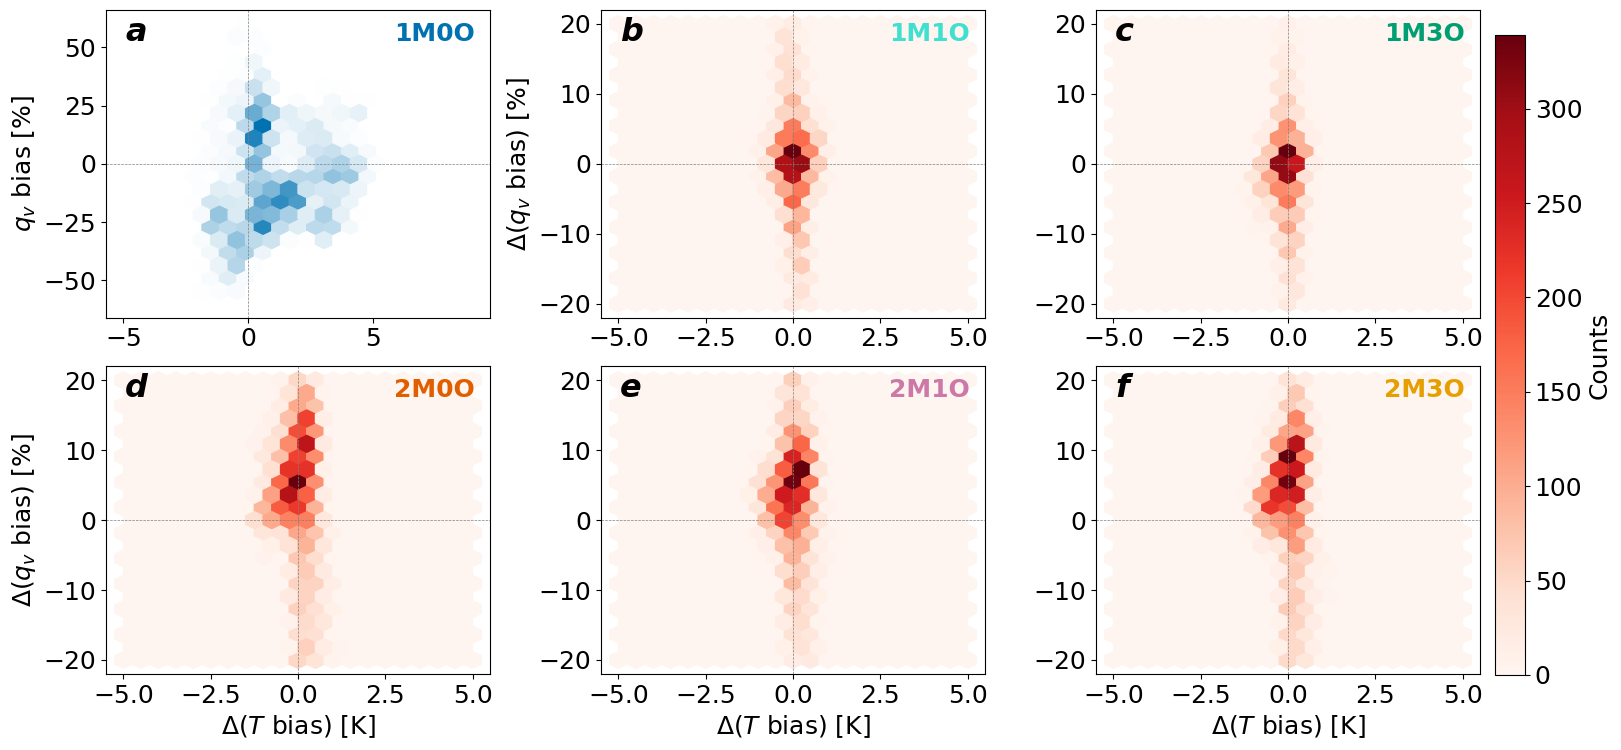

In [7]:
fs = 18
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
panel_labels = ['a','b','c','d','e','f']

for (idx, ax), sl in zip(enumerate(axs.flat), sim_list):
    # Create a contourf plot with the temperature and specific humidity biases
    if idx == 0:
        cmap = LinearSegmentedColormap.from_list("custom_seq", ["white", farbe[sl]])
        ax.hexbin( vals[idx,0], vals[idx,1], gridsize=20, extent=[-5, 9, -60, 60], cmap=cmap )
    else:
        print( np.nanmin(vals[idx,0]-vals[0,0]), np.nanmean(vals[idx,0]-vals[0,0]), np.nanmax(vals[idx,0]-vals[0,0]) )
        print( np.nanmin(vals[idx,1]-vals[0,1]), np.nanmean(vals[idx,1]-vals[0,1]), np.nanmax(vals[idx,1]-vals[0,1]) )
        hb = ax.hexbin( vals[idx,0]-vals[0,0], vals[idx,1]-vals[0,1], gridsize=20, extent=[-5, 5, -20, 20], cmap='Reds' )
    ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.tick_params(labelsize=fs)
    if idx == 0:
        ax.set_ylabel(r"$q_v$ bias [%]", fontsize=fs)
    if idx == 1 or idx == 3:
        ax.set_ylabel(r"$\Delta (q_v$ bias) [%]", fontsize=fs)
    if idx // 3 == 1:
        ax.set_xlabel(r"$\Delta (T$ bias) [K]", fontsize=fs)
    ax.text(0.05, 0.9, panel_labels[idx], transform=ax.transAxes, fontstyle='italic', fontsize=fs+5, fontweight='bold')
    ax.text(0.75, 0.9, sl, transform=ax.transAxes, fontsize=fs, color=farbe[sl], fontweight='bold')

# Create a single vertical colorbar spanning both rows of subplots
cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.8])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.set_label('Counts', fontsize=fs)
cbar.ax.tick_params(labelsize=fs)
plt.tight_layout(rect=[0, 0, 1, 0.95])

#fig.savefig( 'output/T-qv-joint-distributions-differences' + tag + '.pdf', bbox_inches='tight' )
plt.show()

# Figure 7: Updraft velocity PDF + gravity wave spectrum

In [4]:
# Load the observational w values and evaluate their histogram.
high_w = 3
low_w = 0.001
nbin = 70

# Filter for UTLS updrafts and downdrafts
basedir = '/groups/sylvia/UTLS-profiles/obs/POSIDON/'
posidon_winds = pd.read_csv(basedir + 'posidon_vertical_wind2.dat',sep='\s+')
pp = posidon_winds['p'].values
ww = posidon_winds['w'].values
posidon_utls_updrafts = ww[(pp <= 200) & (pp >= 70) &  (ww > 0) & (~np.isnan(ww))]
posidon_utls_downdrafts = ww[(pp <= 200) & (pp >= 70) &  (ww < 0) & (~np.isnan(ww))]

# Min and max
basedir = '/groups/sylvia/UTLS-profiles/obs/ATTREX/'
attrex_winds = pd.read_csv(basedir + 'attrex3_vertical_wind2.dat',sep='\s+')
pp = attrex_winds['p'].values
ww = attrex_winds['w'].values
attrex_utls_updrafts = ww[(pp <= 200) & (pp >= 70) &  (ww > 0) & (~np.isnan(ww))]
attrex_utls_downdrafts = ww[(pp <= 200) & (pp >= 70) &  (ww < 0) & (~np.isnan(ww))]

w_list = [posidon_utls_updrafts, np.abs(posidon_utls_downdrafts), attrex_utls_updrafts, np.abs(attrex_utls_downdrafts)]
w_name = ['POSIDON_up', 'POSIDON_down', 'ATTREX_up', 'ATTREX_down']

In [5]:
# Calculate histograms across the two campaigns
h_list = {}
bin_list = {}
for i, (ww, nm) in enumerate(zip(w_list, w_name)):
    print( nm + ', Mean w: ' + str(np.nanmean(ww)) + ', Stdev w: ' + str(np.nanstd(ww)) )
    wgts = np.ones_like(ww)/len(ww) * 100
    bin_edges = np.logspace(np.log(low_w), np.log(high_w), nbin)
    h_list[nm], bin_list[nm] = np.histogram(ww, bins=bin_edges, weights=wgts)

POSIDON_up, Mean w: 0.3958701501515397, Stdev w: 0.3064792795204398
POSIDON_down, Mean w: 0.40312332692307684, Stdev w: 0.45062817467364463
ATTREX_up, Mean w: 0.1993513530886418, Stdev w: 0.171577787809654
ATTREX_down, Mean w: 0.19595016167160287, Stdev w: 0.1628789923005109


In [6]:
# Load the updraft and downdraft histogram values here to plot
# These are evaluated within Analysis_article3.ipynb
bd = '/groups/sylvia/UTLS-profiles/output/'
with open( bd + "hup_by_sim.pkl", "rb" ) as f:
    hup_by_sim = pickle.load( f )
with open( bd + "hdown_by_sim.pkl", "rb" ) as f:
    hdown_by_sim = pickle.load( f )   

In [7]:
# Create a Butterworth filter - per Aurelien Podglajen's advice
def butterworth_filter( data, cutoff, fs, order=4, btype='low' ):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    y = filtfilt( b, a, data )
    return y, (a,b)

In [8]:
# Power spectra of balloon measurements
# Load observations of temperature and updraft
bd = '/groups/sylvia/UTLS-profiles/obs/Strateole-2/'
fi = [ 'ST2_C0_01_STR1_tsen.nc', 'ST2_C0_02_STR2_tsen.nc', 'ST2_C0_03_TTL3_tsen.nc', 'ST2_C0_04_TTL1_tsen.nc',
       'ST2_C0_05_TTL2_tsen.nc', 'ST2_C0_06_STR1_tsen.nc', 'ST2_C0_07_STR2_tsen.nc', 'ST2_C0_08_STR2_tsen.nc' ]
total = sum( [xr.open_dataset( bd + f )['time'].shape[0] for f in fi] )
print( total )

g = 9.8 # gravitational acceleration [m s-2]
cp = 1000 # specific heat capacity of air [J kg-1 K-1] at -70 C and 1 bar
Tprime = np.zeros((total,))
wprime = np.zeros((total,))
l = 0
alpha = 0.3 # Factor from Aurelien Podglajen - "altitude anomaly before computing temperature anomaly"
for f in fi:
    alt = xr.open_dataset( bd + f )['alt']
    zfluc_raw = (alt - np.nanmean(alt))/alpha
    zfluc, _ = butterworth_filter( zfluc_raw, 1./(15.*60), 1./30., order=4, btype='low') # filter periods above 15 min
    tfluc = -zfluc * g / cp
    
    # Calculate the vertical velocity as the finite difference in altitude
    # divided by the 30 second temporal resolution
    w = np.diff(alt) / 30.
    wfluc = w - np.nanmean(w)
    
    wprime[l:l+len(wfluc)] = wfluc
    Tprime[l:l+len(tfluc)] = tfluc
    l = l + len(tfluc)
    
# Remove any nans from Tprime + wprime
Tprime = Tprime[~np.isnan(Tprime)]
wprime = wprime[~np.isnan(wprime)]

1943296


In [9]:
# Fixed set of frequencies
n = 8000
freq = np.linspace(0,0.4999,n)

# Generate an instance of Class traj_psd with temp = input T time series
traj_obj = traj_psd( Tprime )
traj_obj2 = traj_psd( wprime )

# Calculate the power spectral density
ff, Pxx, _ = traj_obj.calc_psd()
ff2, Pxx2, _ = traj_obj2.calc_psd()
    
 # Interpolate the PSD to a fixed set of frequencies
f = interpolate.interp1d(ff, Pxx, kind='cubic')
T_PSD_Strateole = f(freq)
f2 = interpolate.interp1d(ff2, Pxx2, kind='cubic')
w_PSD_Strateole = f2(freq)

In [10]:
# Load the ICON power spectra on the basis of trajectories
bd = '/groups/sylvia/UTLS-profiles/output/PSD/'
T_ff_0V2M0A0R = np.load( bd + 'T_PSD_ff_0V2M0A0R_traj_ICON.npy' )
T_Pxx_0V2M0A0R = np.load( bd + 'T_PSD_Pxx_0V2M0A0R_traj_ICON.npy' )

T_ff_0V2M0A0R_Tf = np.load( bd + 'T_PSD_ff_0V2M0A0R_traj_Tf2.npy' )
T_Pxx_0V2M0A0R_Tf = np.load( bd + 'T_PSD_Pxx_0V2M0A0R_traj_Tf2.npy' )

w_ff_0V2M0A0R = np.load( bd + 'w_PSD_ff_0V2M0A0R_traj_ICON.npy' )
w_Pxx_0V2M0A0R = np.load( bd + 'w_PSD_Pxx_0V2M0A0R_traj_ICON.npy' )

# Load the updraft histograms from the ICON high-resolution simulations
#h_0V2M0A0R = np.load( bd +  'traj_w_histogram_ICON_0V2M0A0R.npy' )
#h_0V2M0A0R_1015km = np.load( bd + 'traj_w_histogram_ICON_0V2M0A0R_10-15km.npy' )

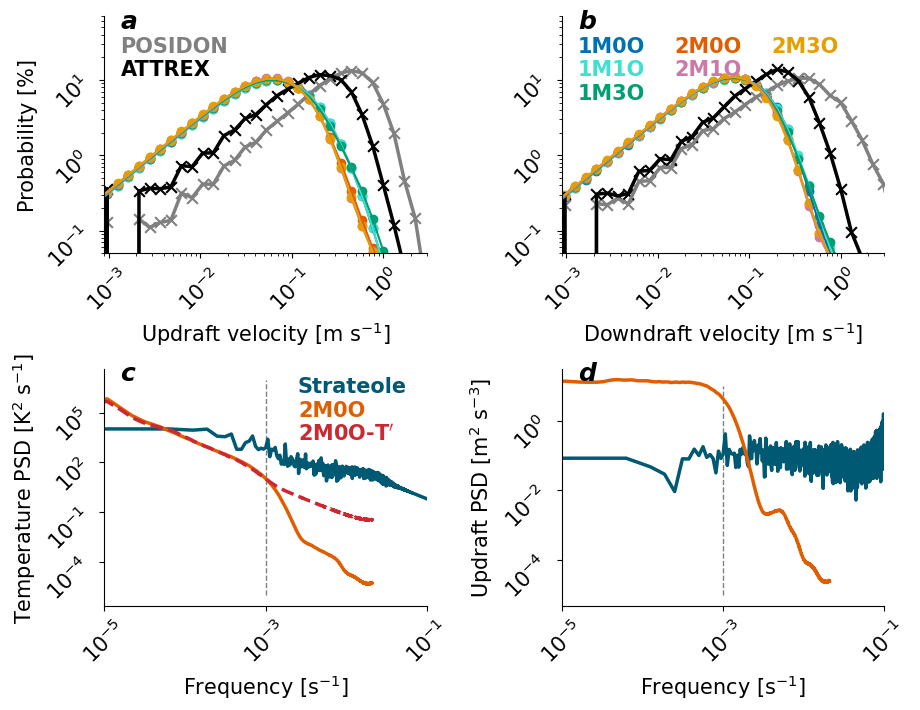

In [16]:
# Plot parameters
fs = 15
lw = 2.5
ms = 60
lab = [r'Updraft velocity [m s$^{-1}$]', r'Downdraft velocity [m s$^{-1}$]', r'Frequency [s$^{-1}$]', r'Frequency [s$^{-1}$]']
let = ['a', 'b', 'c', 'd']
pos = [[0.05, 0.85], [0.05, 0.75], [0.05, 0.65], [0.35, 0.85], [0.35, 0.75], [0.65, 0.85]]

# Setup
def line_x(a, y, centers, color, lw=lw, label=None):
    a.plot(centers, y, color=color, lw=lw, label=label)
def xmarks(a, y, centers, color, s=ms):
    a.scatter(centers, y, s=s, marker='x', color=color)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9.3, 7.2))
(a0, a1), (a2, a3) = ax

# PANELS A and B: PDFs of updrafts
for j, w in enumerate(w_name):
    centers=(bin_list[w][1:] + bin_list[w][:-1]) * 0.5
    if j%2 == 0:
        line_x(a0, h_list[w], centers=centers, color=farbe[w[:-3]])
        xmarks(a0, h_list[w], centers=centers, color=farbe[w[:-3]])
    else:
        line_x(a1, h_list[w], centers=centers, color=farbe[w[:-5]])
        xmarks(a1, h_list[w], centers=centers, color=farbe[w[:-5]])

for i, sl in enumerate(sim_list):
    bin_centers = (hup_by_sim[sl][0][1:] + hup_by_sim[sl][0][:-1])/2
    a0.plot( bin_centers, hup_by_sim[sl][1], color=farbe[sl] )
    a0.scatter( bin_centers, hup_by_sim[sl][1], color=farbe[sl] )
    bin_centers = (hdown_by_sim[sl][0][1:] + hdown_by_sim[sl][0][:-1])/2
    a1.plot( bin_centers, hdown_by_sim[sl][1], color=farbe[sl] )
    a1.scatter( bin_centers, hdown_by_sim[sl][1], color=farbe[sl] )
    a1.text( pos[i][0], pos[i][1], sl, color=farbe[sl], weight='bold', fontsize=fs, transform=a1.transAxes )
        
# PANELS C and D: Power spectra of updrafts
a2.plot( [10**(-3), 10**(-3)], [10**(-6), 10**7], color='gray', lw=1, ls='--' )
a2.plot( freq, T_PSD_Strateole, color=farbe['Sonde'], lw=lw )
a2.plot( np.nanmean(T_ff_0V2M0A0R,axis=0), np.nanmean(T_Pxx_0V2M0A0R,axis=0), lw=lw, color=farbe['2M0O'])
a2.plot( np.nanmean(T_ff_0V2M0A0R_Tf,axis=0), np.nanmean(T_Pxx_0V2M0A0R_Tf,axis=0), ls='--', lw=lw, color=farbe['2M0O-Tprime'])

a3.plot( [10**(-3), 10**(-3)], [10**(-5), 10], color='gray', lw=1, ls='--' )
a3.plot( freq, w_PSD_Strateole, color=farbe['Sonde'], lw=lw )
a3.plot(np.nanmean(w_ff_0V2M0A0R,axis=0), np.nanmean(w_Pxx_0V2M0A0R,axis=0), linewidth=lw, color=farbe['2M0O'])
# Why is there no power spectra + temperature fluctuations recorded for w?
#a3.plot(np.nanmean(w_ff_0V2M0A0R,axis=0), np.nanmean(w_Pxx_0V2M0A0R,axis=0), linewidth=lw, color=farbe['2M0O-Tprime'])

# Axis text and aesthetics
a0.text( 0.05, 0.85, 'POSIDON', fontsize=fs, weight='bold', color=farbe['POSIDON'], transform=a0.transAxes )
a0.text( 0.05, 0.75, 'ATTREX',  fontsize=fs, weight='bold', color=farbe['ATTREX'],  transform=a0.transAxes )
a2.text( 0.6, 0.9, 'Strateole', fontsize=fs, weight='bold', color=farbe['Sonde'], transform=a2.transAxes )
a2.text( 0.6, 0.8, '2M0O', fontsize=fs, weight='bold', color=farbe['2M0O'], transform=a2.transAxes )
a2.text( 0.6, 0.7, r'2M0O-T$^{\prime}$', fontsize=fs, weight='bold', color=farbe['2M0O-Tprime'], transform=a2.transAxes )
a0.set_ylabel('Probability [%]', fontsize=fs)
a2.set_ylabel('Temperature PSD [K$^2$ s$^{-1}$]', fontsize=fs)
a3.set_ylabel('Updraft PSD [m$^2$ s$^{-3}$]', fontsize=fs)
a2.set_xlim([10**(-5), 10**(-1)])
a3.set_xlim([10**(-5), 10**(-1)])
for i, a in enumerate(ax.flatten()):
    a.set_yscale('log')
    a.set_xscale('log')
    a.set_xlabel( lab[i], fontsize=fs )
    a.text( 0.05, 0.95, let[i], fontsize=fs+3, weight='bold', style='italic', transform=a.transAxes )
    sexy_axes(a, fs, r=True)
    if i < 2:
        a.set_ylim( [0.05, 70] )
        a.set_xlim( [0.9*low_w, high_w] )

plt.tight_layout()
fig.savefig( 'output/dynamics.pdf', bbox_inches='tight' )
plt.show()

# Figure 8: Ice mass mixing ratio over time

In [22]:
basedir = '/groups/sylvia/UTLS-profiles/output/'
syn_traj = xr.open_dataset(basedir + 'ICON_synthetic_trajs_1M0O_E.nc')
w_sim = syn_traj.w.values
qi_sim = syn_traj.qi * conv * 10**6 # [kg kg-1]
print_stats(qi_sim)
qi_masked = xr.where( qi_sim < 0.001, np.nan, qi_sim )
t = syn_traj.time.values # DataArray of length 12770

# Read in-situ data
daten = xr.open_dataset('/groups/sylvia/UTLS-profiles/obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
qi_Stratoclim = daten['BEST:IWC']
qi_sc_masked = xr.where( qi_Stratoclim < 0.001, np.nan, qi_Stratoclim )
print_stats( qi_sc_masked )
t_Stratoclim = daten['time']

Min / Median / Mean / Max: 
0.0 3.3111688138355976e-06 5.844321813665948 401.61178680395216
Min / Median / Mean / Max: 
0.0015181382 1.4181218 43.11809 1281.5779


In [23]:
# Identify the best trajectory
jbest = best_track( qi_sim, qi_sc_masked )
qidiff = qi_masked - qi_sc_masked
print_stats( qidiff )
print( jbest )
best_traj = qidiff[:, jbest]
print_stats( best_traj )

Min / Median / Mean / Max: 
-1281.5708297128062 -6.043217119274267 -34.39786804923947 354.63315306887074
1
Min / Median / Mean / Max: 
-1281.413251235867 -5.683301700488505 -35.035047903177215 354.33480802094914


/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator


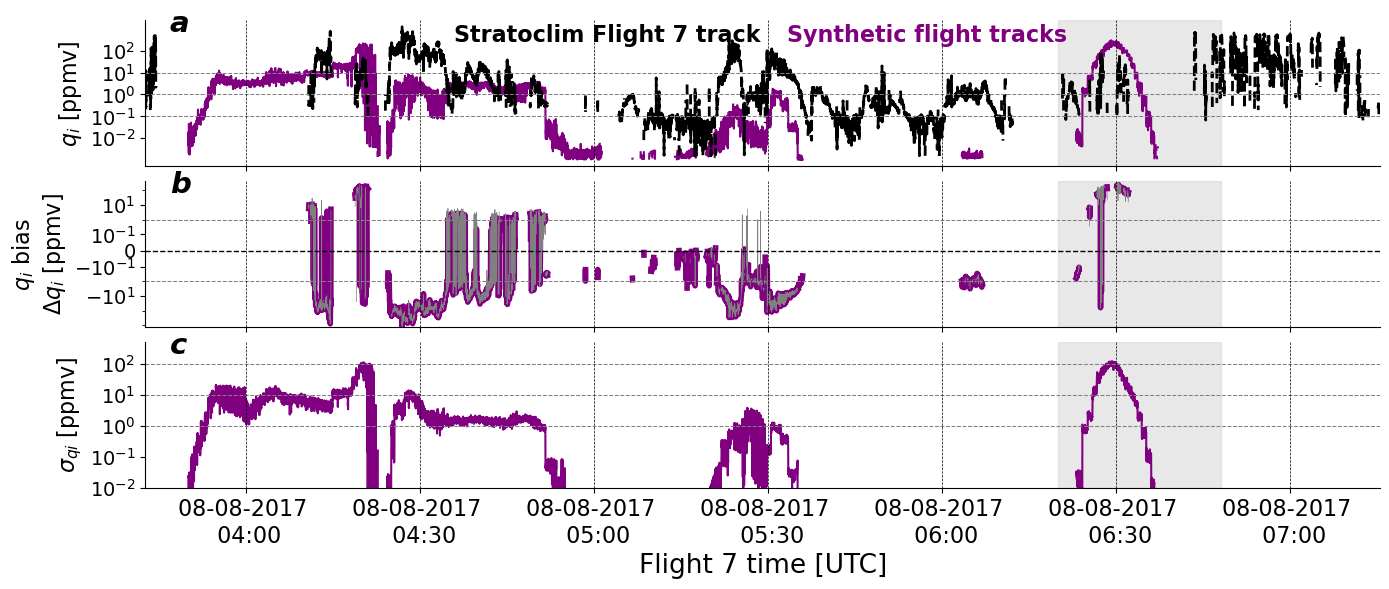

In [27]:
fs = 16
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 6))
let = ['a', 'b', 'c']#, 'd', 'e']

for i, a, l in zip(range(3), ax, let):
    a.set_xlim([t.min(), t.max()])
    a.axvspan(np.datetime64('2017-08-08T06:20'),
              np.datetime64('2017-08-08T06:48'),
              color='lightgray', alpha=0.5)
    sexy_axes(a, fs=fs, r=False)
    a.text(0.02, 0.92, l, weight='bold', style='italic', fontsize=fs+5, transform=a.transAxes)
    if i < 2:
        a.set_xticklabels([])
    
yticks_list = [ [1e-2, 1e-1, 1, 10, 100],[-10, -0.1, 0, 0.1, 10],
                [1e-2, 1e-1, 1, 10, 100] ]
#[-0.1, 0, 0.1, 0.2, 0.3], [0, 0.1, 0.2, 0.3],
        
#wm = np.nanmean( w_sim, axis=1 )
#wstd = np.nanstd( w_sim, axis=1 )
qim = np.nanmedian( qi_masked, axis=1 )
qistd = np.nanstd( qi_masked, axis=1 )

#ax[0].plot(t, wm, color='seagreen')
#ax[0].set_ylabel(r'$w$ [m s$^{-1}$]', fontsize=fs)
#ax[0].axhline(y=0, color='k', ls='--', lw=1)
#ax[0].axhline(y=0.1,  color='gray', ls='--', lw=0.75)
#ax[0].axhline(y=-0.1, color='gray', ls='--', lw=0.75)
#ax[0].text(0.3, 0.75, 'Synthetic flight tracks', weight='bold', fontsize=fs,
#           color='seagreen', transform=ax[0].transAxes)

#ax[1].plot(t, wstd, color='seagreen')
#ax[1].axhline(y=0.2, color='gray', ls='--', lw=0.75)
#ax[1].set_ylabel(r'$\sigma_w$ [m s$^{-1}$]', fontsize=fs)

ax[0].plot(t, qim, color='purple')
ax[0].plot(t_Stratoclim, qi_sc_masked, color='k', lw=2, ls='--')
ax[0].set_ylabel(r'$q_i$ [ppmv]', fontsize=fs)
ax[0].axhline(y=10,   color='gray', ls='--', lw=0.75)
ax[0].axhline(y=1,   color='gray', ls='--', lw=0.75)
ax[0].axhline(y=0.1, color='gray', ls='--', lw=0.75)
ax[0].text(0.25, 0.85, 'Stratoclim Flight 7 track', weight='bold', fontsize=fs, transform=ax[0].transAxes)
ax[0].text(0.52, 0.85, 'Synthetic flight tracks',  weight='bold', fontsize=fs, color='purple', transform=ax[0].transAxes)

#ax[1].plot(t, np.nanmedian(qidiff, axis=1), lw=4, color='purple')
ax[1].plot(t, qim - qi_sc_masked, lw=4, color='purple' )
ax[1].plot(t, best_traj, color='gray', lw=0.5)
ax[1].axhline(y=1, color='gray', ls='--', lw=0.75)
ax[1].axhline(y=-1, color='gray', ls='--', lw=0.75)
ax[1].axhline(y=0, color='k', ls='--', lw=1)
ax[1].set_ylabel(r'$q_i$ bias' '\n' '$\Delta q_i$ [ppmv]', fontsize=fs)

ax[2].plot(t, qistd, color='purple')
ax[2].set_ylabel(r'$\sigma_{qi}$ [ppmv]', fontsize=fs)
ax[2].axhline(y=100, color='gray', ls='--', lw=0.75)
ax[2].axhline(y=10, color='gray', ls='--', lw=0.75)
ax[2].axhline(y=1, color='gray', ls='--', lw=0.75)
ax[2].set_xticklabels(['08-08-2017 \n 04:00', '08-08-2017 \n 04:30','08-08-2017 \n 05:00','08-08-2017 \n 05:30',
    '08-08-2017 \n 06:00','08-08-2017 \n 06:30','08-08-2017 \n 07:00'])
ax[2].set_xlabel('Flight 7 time [UTC]', fontsize=fs+3)

#ax[0].set_yticks([-0.1, 0, 0.1, 0.2, 0.3])
#ax[1].set_yticks([0, 0.1, 0.2, 0.3])
ax[0].set_yscale('log')
ax[1].set_yscale('symlog',linthresh=1e-1,linscale=1.0,base=10)
ax[2].set_yscale('log')
ax[2].set_ylim([10**(-2), 500])

for xtick in ax[2].get_xticks():
    for a in ax:
        a.axvline(x=xtick, color='k', ls='--', lw=0.5)

for i in (0, 1, 2):
    ax[i].set_yticks(yticks_list[i])

for a in ax:
    a.tick_params(axis='y', labelsize=fs-2)
    a.tick_params(axis='x', labelsize=fs)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
fig.savefig('output/syn-flight-track-qi.pdf',bbox_inches='tight')
plt.show()

# Figure 9: Ice mass mixing ratio profile comparisons

In [60]:
# Which set of trajectory statistics do you want to open?

tag = '_E'  # E = 'extract', default 20 synthetic trajectories
#tag = '_E2' # Second (or third) set of 20 synthetic trajectories to test reproducibility
#tag = '_C' # C = 'collocate', minimize the Euclidean distance between sim and obs values
#tag = '_P' # P = 'pinpoint', find the closest numerical value to the obs within the sim
#tag = '_full' # Statistics over the full Flight 7 track

bd = '/groups/sylvia/UTLS-profiles/output/'
stats = []
for s in sim_list: 
    ds = xr.open_dataset( bd + 'ICON_synthetic_trajs_stats_' + s + tag + '.nc' )
    stats.append( ds )
plev = ds.pressure

In [68]:
min_alt = 5000
max_alt = 22000
icon_sz = 50
    
# Time range from Lee et al. 2019 (6:20-6:48 UTC)    
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)

# Full Flight 7 statistics
#time0 = datetime(2017, 8, 8, 4, 0)
#timef = datetime(2017, 8, 8, 7, 15)

In [69]:
# Suppress warnings about levels where there are no data
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
warnings.filterwarnings("ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")

# Read in-situ data
p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )

# Bin the in-situ data by pressure levels from the simulation
bins_sims, _, _, _, _, qi_SC_stats, RHi_SC_stats = \
    bin_flighttrack_general( plev.values, p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish )

In [70]:
# Read in statistics from the best-performing trajectory
best_stats = xr.open_dataset( '/groups/sylvia/UTLS-profiles/output/ICON_synthetic_trajs_stats_1M0O_E-best.nc' )

# Simulation data averaged over the whole domain, not just the flight track
sim_ds = xr.open_dataset( '/groups/sylvia/UTLS-profiles/output/mean-T-qv-qi-profiles.nc' )

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


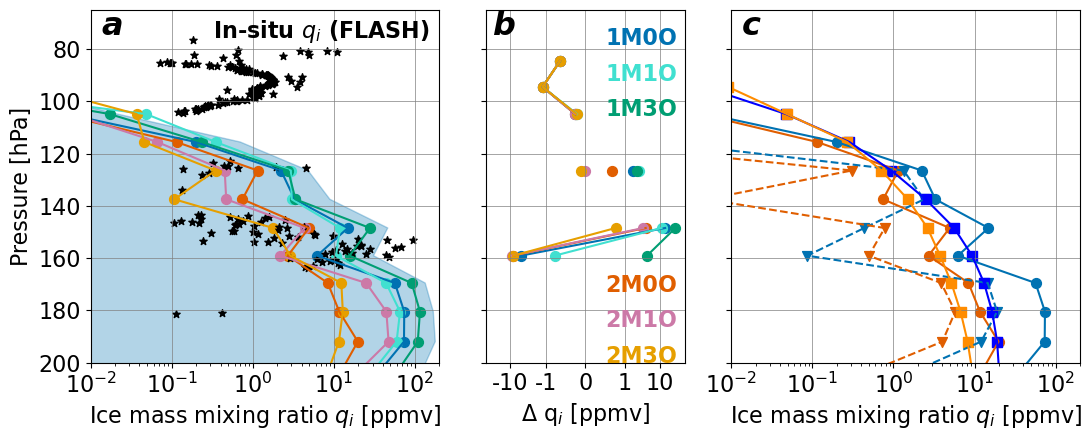

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(11, 4.5), gridspec_kw={'width_ratios': [1.75, 1, 1.75]})
axs = list(ax.flatten())
let = ['a', 'b', 'c']

# Other plotting parameters
icon_lw = 1.5
icon_alfa = 1
fs = 16
yval = plev/100 # Convert Pa -> hPa

# Specify whether to compare means (l = 0) or medians (l = 1)
k = 'mean'; l = 1

# Axis limits specified
for i, a in enumerate(axs):
    a.set_ylim([65, 200])
    a.grid(b=True, which='major', axis='both', color='gray', linewidth=0.5)
    a.tick_params('both',labelsize=fs)
    a.invert_yaxis()
    a.text(0.03, 0.93, let[i], weight='bold', style='italic', fontsize=fs+7, transform=a.transAxes)
ax[0].set_xlim([10**(-2), 2*10**2])
ax[1].set_xlim([-50, 50])
ax[2].set_xlim([10**(-2), 2*10**2])

# PANEL A: Mean (or median) qi over all trajectories
qim = np.nanmean( stats[0]['qi_'+k], axis=1 )
qistd = np.nanmean( stats[0]['qi_std'], axis=1 )
ax[0].fill_betweenx( y=yval, x1=qim-qistd, x2=qim+qistd, alpha=0.3, color=farbe['1M0O'] )
ax[0].scatter( qi_obs, p2, color='k', s=10, marker='*')
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    qim = np.nanmean( stats[i]['qi_'+k], axis=1 )
    ax[0].scatter( qim, yval, s=icon_sz, color=farbe[sl] )
    ax[0].plot( qim, yval, lw=icon_lw, color=farbe[sl] )
ax[0].scatter(qi_obs, p2, color='k', s=30, marker='*')
ax[0].text(0.35, 0.92, 'In-situ $q_i$ (FLASH)', fontsize=fs, weight='bold', transform=ax[0].transAxes)
ax[0].set_xlabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)
ax[0].set_ylabel('Pressure [hPa]',fontsize=fs)
ax[0].set_xscale('log')

# PANEL B: qi biases
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    qim = np.nanmean( stats[i]['qi_'+k], axis=1 )
    ax[1].scatter( qim-qi_SC_stats[l], yval, s=icon_sz, alpha=icon_alfa, color=farbe[sl] )
    ax[1].plot( qim-qi_SC_stats[l], yval, lw=icon_lw, color=farbe[sl] )
    if i < 3:
        ax[1].text(0.6, 0.9-i*0.1, sl, fontsize=fs, weight='bold', color=farbe[sl], transform=ax[1].transAxes)
    else:
        ax[1].text(0.6, 0.5-i*0.1, sl, fontsize=fs, weight='bold', color=farbe[sl], transform=ax[1].transAxes)
ax[1].set_yticklabels([])
ax[1].set_xlabel(r'$\Delta$ q$_i$ [ppmv]', fontsize=fs)
ax[1].set_xscale('symlog',linthresh=1)
ax[1].set_xticklabels([-10,-1,0,1,10])
ax[1].set_xticklabels(['-10', '-1', '0', '1', '10']) 

# PANEL C: illustrations of spatial localization of ice clouds
ax[2].scatter( np.nanmean(stats[0]['qi_mean'], axis=1), yval, s=icon_sz, color=farbe['1M0O'] )
ax[2].plot( np.nanmean(stats[0]['qi_mean'], axis=1), yval, color=farbe['1M0O'] )
ax[2].scatter( np.nanmean(stats[3]['qi_mean'], axis=1), yval, s=icon_sz, color=farbe['2M0O'] )
ax[2].plot( np.nanmean(stats[3]['qi_mean'], axis=1), yval, color=farbe['2M0O'] )
ax[2].scatter( np.nanmedian(stats[0]['qi_median'], axis=1), yval, marker='v', s=icon_sz, color=farbe['1M0O'] )
ax[2].plot( np.nanmedian(stats[0]['qi_median'], axis=1), yval, ls='--', color=farbe['1M0O'] )
ax[2].scatter( np.nanmedian(stats[3]['qi_median'], axis=1), yval, marker='v', s=icon_sz, color=farbe['2M0O'] )
ax[2].plot( np.nanmedian(stats[3]['qi_median'], axis=1), yval, ls='--', color=farbe['2M0O'] )
qim = sim_ds.sel(simulation='1M0O')['mean_qi'] * conv * 10**6
ax[2].scatter( qim, yval, marker='s', s=icon_sz, color='blue' )
ax[2].plot( qim, yval, color='blue' )
qim = sim_ds.sel(simulation='2M0O')['mean_qi'] * conv * 10**6
ax[2].scatter( qim, yval, marker='s', s=icon_sz, color=(1, 0.55, 0) )
ax[2].plot( qim, yval, color=(1, 0.55, 0) )
ax[2].set_xscale('log')
ax[2].set_yticklabels([])
ax[2].set_xlabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
fig.savefig( 'output/qi-profile-comparison' + tag + '.pdf', bbox_inches='tight' )
plt.show()

# OLR maps to assess overshoot strength

In [55]:
bd = '/xdisk/sylvia/0V1M0A0R0O/RAD_2D/'
ds = xr.open_dataset( bd + 'RAD_2D_icon_tropic_0146.nc' ) #50 - 20170806T1300 UTC // 98 - 20170807T1300 UTC // 146 - 201708080T0600
lon = ds.lon
lat = ds.lat
olr = -1.*ds['thb_t'].isel(time=0)
print_stats( olr )
lower = np.nanpercentile( olr, 1 )
upper = np.nanpercentile( olr, 99 )
print( lower, upper )
print( ds.time.values )

# Monthly frequency of CERES does me no good
#bd_obs = '/groups/sylvia/UTLS-profiles/obs/'
#ds_obs = xr.open_dataset( bd_obs + 'CERES_EBAF-TOA_Ed4.2.1_Subset_201708-201708.nc' )
#olr_obs = ds_obs['toa_lw_all_mon']

bd_obs = '/groups/sylvia/UTLS-profiles/obs/'
ds_obs = xr.open_dataset( bd_obs + 'olr-daily_v01r02_20170101_20171231.nc' )
lon_obs = ds_obs['lon']
lat_obs = ds_obs['lat']
olr_obs = ds_obs['olr'].sel(time='2017-08-08T12:00:00.000000000')

Min / Median / Mean / Max: 
-0.0 253.72481 241.07375 370.26022
101.4209213256836 350.2027587890625
['2017-08-08T13:00:00.000000000']


/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/u1

Text(0.02, 1.05, 'b')

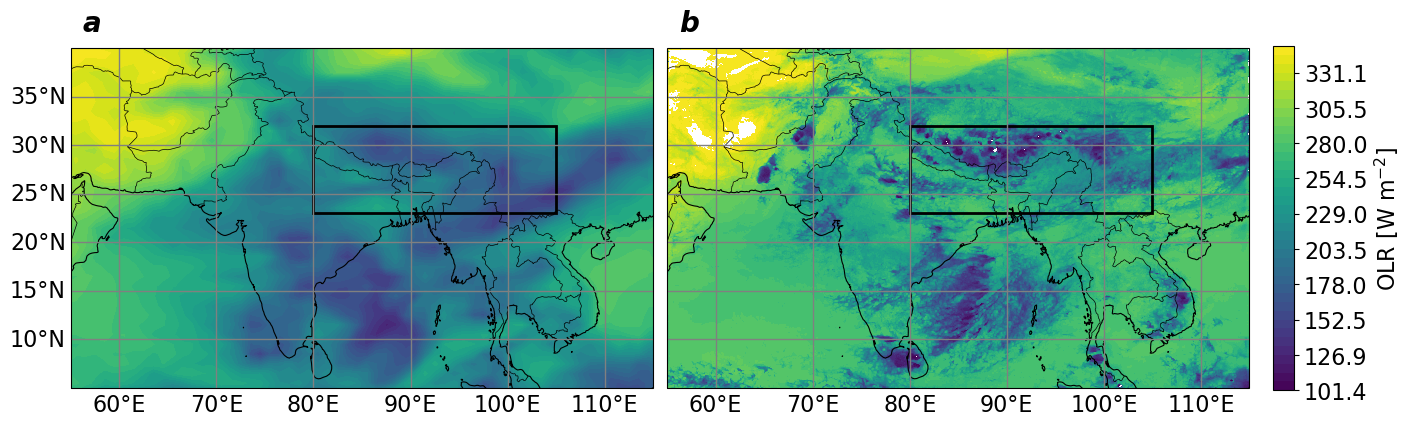

In [56]:
fs = 16
fig = plt.figure( figsize=(14,5), constrained_layout=True )
gs = fig.add_gridspec(1,2)

ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax1 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())

for j, a in zip(np.arange(2), (ax0, ax1)):
    gl = a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size':fs}
    gl.ylabel_style = {'size':fs}
    a.set_xlabel(r'Latitude [$^{\circ}$N]',fontsize=fs)
    a.set_ylabel(r'Longitude [$^{\circ}$E]',fontsize=fs)
    if j == 1:
        gl.left_labels = False
    a.set_extent([55, 115, 5, 40],crs=ccrs.PlateCarree())

levels = np.linspace( lower, upper, 40 )
cf = ax0.contourf( lon_obs, lat_obs, olr_obs, levels=levels, cmap="viridis", transform=ccrs.PlateCarree() )
ax0.coastlines(linewidth=0.8)
ax0.add_feature(cfeature.BORDERS, linewidth=0.5)
ax0.add_patch( mpatches.Rectangle((80, 23), 105-80, 32-23,
                                edgecolor='black', facecolor='none', linewidth=2,
                                transform=ccrs.PlateCarree()))
ax0.text(0.02 ,1.05, 'a', weight='bold', fontstyle='italic', fontsize=fs+4, transform=ax0.transAxes)

cf = ax1.contourf( lon, lat, olr, levels=levels, cmap="viridis", transform=ccrs.PlateCarree() )
ax1.coastlines(linewidth=0.8)
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_patch( mpatches.Rectangle((80, 23), 105-80, 32-23,
                                edgecolor='black', facecolor='none', linewidth=2,
                                transform=ccrs.PlateCarree()))
c = fig.colorbar( cf, ax=ax1, fraction=0.05, pad=0.04, shrink=0.7, aspect=16, anchor=(0.0, 0.5), )
c.set_label(r'OLR [W m$^{-2}$]',fontsize=fs)
c.ax.tick_params(labelsize=fs)
ax1.text(0.02 ,1.05, 'b', weight='bold', fontstyle='italic', fontsize=fs+4, transform=ax1.transAxes)


# former Figure 2: Trajectories over domain

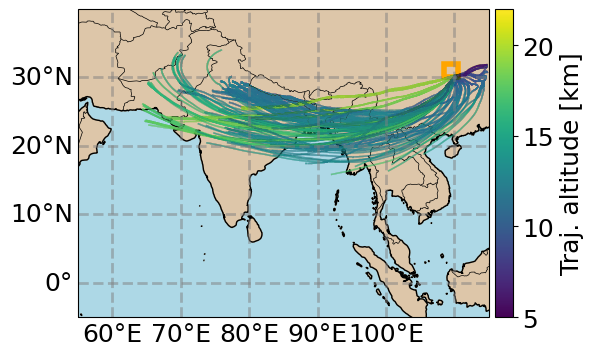

In [20]:
fs = 18
fig = plt.figure(figsize=(6,4))
gs = fig.add_gridspec(1,1)
ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())

ax0.coastlines()
ax0.set_extent([55, 115, -5, 40],crs=ccrs.PlateCarree())

gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fs}
gl.ylabel_style = {'size': fs}
ax0.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax0.add_feature(cfeature.LAND, facecolor='tan', alpha=0.75)
ax0.add_feature(cfeature.BORDERS, linewidth=0.5)

# Create and add a rectangle for the small subdomain
lon_min, lon_max = 108.5, 110.5
lat_min, lat_max = 30, 32
box = mpatches.Rectangle( (lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth=4,
    edgecolor='orange', facecolor='none', transform=ccrs.PlateCarree() )
ax0.add_patch(box)

# How many trajectories to plot? Overlay on topography in purple.
norm = plt.Normalize(5,22)
n = 150
for i in np.arange(n):
    points = np.array([traj_lon[:,i], traj_lat[:,i]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='viridis', norm=norm, rasterized=True)  # <--- rasterized=True
    lc.set_array(traj_alt[:,i])
    lc.set_linewidth(1)
    ax0.add_collection(lc)

sm = plt.cm.ScalarMappable(cmap='viridis',norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])

def resize_colorbar(event):
    plt.draw()
    posn = ax0.get_position()
    cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0, 0.03, posn.height])
    
fig.canvas.mpl_connect('resize_event', resize_colorbar)
c = plt.colorbar(sm, cax=cbar_ax)
c.set_label('Traj. altitude [km]',fontsize=fs)
c.ax.tick_params(labelsize=fs)
resize_colorbar(None)

fig.savefig('/groups/sylvia/UTLS-profiles/output/domain-trajectories.pdf', bbox_inches='tight')
plt.show()

# Old trajectory code (possibly to be revitalized!)

# Scraps - Calculating PSDs from flight track data (not to be compared to Lagrangian trajectories)

In [ ]:
# Fixed set of frequencies
n = 8000
freq = np.linspace(0,0.4999,n)

# Number of POSIDON flights (9)
posidon_dates = posidon_winds['date'].unique()

# Calculate the power spectral density of observational temperature and updraft signals.
T_PSD_POSIDON = np.zeros((len(posidon_dates), n))
w_PSD_POSIDON = np.zeros((len(posidon_dates), n))

for j, date in enumerate(posidon_dates):
    subset = posidon_winds[(posidon_winds['date'] == date)] 
    
    # Generate an instance of Class traj_psd with temp = input T time series
    # The T time series have lengths of 11176, 10480, 11190, 16964, 16208, 15551, 9612, 15899, 10114
    traj_obj = traj_psd(subset['T'].values)
    traj_obj2 = traj_psd(subset['w'].values)
    
    # Calculate the power spectral density
    ff, Pxx, _ = traj_obj.calc_psd()
    ff2, Pxx2, _ = traj_obj2.calc_psd()
    
    # Interpolate the PSD to a fixed set of frequencies
    f = interpolate.interp1d(ff, Pxx, kind='cubic')
    f2 = interpolate.interp1d(ff2, Pxx2, kind='cubic')
    
    # Append the values to the multidimensional list
    T_PSD_POSIDON[j] = f(freq)
    w_PSD_POSIDON[j] = f2(freq)

In [ ]:
# Number of ATTREX flights (6)
attrex_dates = attrex_winds['date'].unique()

# Calculate the power spectral density of observational temperature signals.
T_PSD_ATTREX = np.zeros((len(attrex_dates), n))
w_PSD_ATTREX = np.zeros((len(attrex_dates), n))

for j, date in enumerate(attrex_dates):
    subset = attrex_winds[(attrex_winds['date'] == date)] 
    
    # Generate an instance of Class traj_psd with temp = input T time series
    # The T time series have lengths of 39731, 37179, 32700, 46743, 50830, 36647
    traj_obj = traj_psd(subset['T'].values)
    traj_obj2 = traj_psd(subset['w'].values)
    
    # Calculate the power spectral density
    ff, Pxx, _ = traj_obj.calc_psd()
    ff2, Pxx2, _ = traj_obj2.calc_psd()

    # Interpolate the PSD to a fixed set of frequencies
    f = interpolate.interp1d(ff, Pxx, kind='cubic')
    f2 = interpolate.interp1d(ff2, Pxx2, kind='cubic')
    
    # Append the values to the multidimensional list
    T_PSD_ATTREX[j] = f(freq)
    w_PSD_ATTREX[j] = f2(freq)